# **ОПРАЦЮВАННЯ ДАНИХ**

## Встановлення потрібних бібліотек

In [2]:
import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

## Зчитування набору даних

In [8]:
df = pd.read_csv("filtered_dataset.csv")

In [9]:
print('columns count - ',len(df.columns), '\n')
print('columns: ',list(df.columns))

columns count -  45 

columns:  ['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'H', 'diameter', 'albedo', 'diameter_sigma', 'orbit_id', 'epoch', 'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class', 'rms']


## Врахування відсутніх даних

In [10]:
df.shape

(2000, 45)

### Заміна пропущених на NA та перевірка унікальних

In [11]:
missing = []

for x in df.columns:
    if df[x].isnull().sum() != 0:
        print(x, df[x].isnull().sum())
        missing.append(x)

name 290
prefix 2000
pha 6
H 2
diameter 246
albedo 247
diameter_sigma 246
moid 6
sigma_e 6
sigma_a 6
sigma_q 6
sigma_i 6
sigma_om 6
sigma_w 6
sigma_ma 6
sigma_ad 6
sigma_n 6
sigma_tp 6
sigma_per 6


In [12]:
def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [13]:
df.nunique()

id                2000
spkid             2000
full_name         2000
pdes              2000
name              1710
prefix               0
neo                  2
pha                  2
H                  172
diameter          1650
albedo             473
diameter_sigma     727
orbit_id           129
epoch               19
epoch_mjd           19
epoch_cal           19
equinox              1
e                 2000
a                 2000
q                 2000
i                 2000
om                2000
w                 2000
ma                2000
ad                2000
n                 2000
tp                2000
tp_cal            2000
per               2000
per_y             2000
moid              1983
moid_ld           1984
sigma_e           1947
sigma_a           1955
sigma_q           1920
sigma_i           1934
sigma_om          1977
sigma_w           1971
sigma_ma          1946
sigma_ad          1946
sigma_n           1839
sigma_tp          1972
sigma_per         1968
class      

### Рядки з великою кількістю пропущених значень: 

In [14]:
total_columns = df.shape[1]
rows_missing_data = df.isnull().sum(axis=1)
rows_with_many_missing = rows_missing_data[rows_missing_data > total_columns * 0.5]
rows_with_many_missing

Series([], dtype: int64)

Не було знайдено жодного рядка, де пропущені значення перевищували б 50% всіх колонок. Отже, не існує рядків, що містять переважно пропущені дані і варто було б видалити за цим критерієм.

## Обробка пропущених значень

### Аналіз колонок та методи заповнення

1. **`name` (290 пропущених):**
   - Колонка містить назви астероїдів. У випадку пропущених значень можна позначити ці астероїди як `'Unknown'`.
   - **Метод:** Заповнити значенням `'Unknown'`.

2. **`prefix` (2000 пропущених):**
   - Усі значення у колонці пропущені. Це вказує на те, що вона не несе корисної інформації.
   - **Метод:** Видалити колонку.

3. **`pha` (6 пропущених):**
   - Позначає, чи є астероїд потенційно небезпечним (значення `Y` або `N`). Пропущені значення логічно заповнити як `N` (Not hazardous).
   - **Метод:** Заповнити значенням `'N'`.

4. **`H` (2 пропущених):**
   - Абсолютна зоряна величина є важливою характеристикою, яка впливає на діаметр та інші параметри. 
   - **Метод:** Заповнити медіанним значенням (`median`), оскільки це краще враховує можливі викиди та розподіл даних.

5. **`albedo` (247 пропущених):**
   - Відбивна здатність астероїда. Для заповнення можна використати середнє значення для астероїдів із подібними характеристиками `H`.
   - **Метод:** Групувати за `H` та заповнити середнім значенням у групі.

6. **`diameter` (246 пропущених):**
   - Ключова характеристика. Діаметр можна обчислити за формулою:
     \[
     diameter = \frac{1329}{\sqrt{albedo}} \cdot 10^{-0.2 \cdot H}
     \]
     - Якщо необхідні дані (`H` та `albedo`) доступні, значення буде розраховано. Інакше залишаємо як `NaN`.
   - **Метод:** Розрахувати на основі `H` та `albedo`. Якщо це неможливо, залишити як `NaN`.

7. **`diameter_sigma` (246 пропущених):**
   - Похибка діаметра. Пропущені значення не варто заповнювати через специфіку колонки.
   - **Метод:** Залишити як `NaN`.

8. **Колонки `sigma_*` (по 6 пропущених у кожній):**
   - Похибки орбітальних характеристик. Через складність їх обчислення та відсутність чітких формул залишаємо пропущені значення.
   - **Метод:** Залишити як `NaN`.

9. **`moid` (6 пропущених):**
   - Мінімальна орбітальна відстань до Землі. Логічно заповнити середнім значенням у групах, утворених за орбітальними параметрами (`e`, `a`, `i`).
   - **Метод:** Заповнити середнім у групах, сформованих за орбітальними параметрами.

---

### Загальний підхід до обробки
- Видалити неінформативні колонки (`prefix`).
- Для критично важливих характеристик (`diameter`, `H`, `albedo`) відновити значення на основі формул та групувань.
- Для похибок (`diameter_sigma`, `sigma_*`) залишити пропущені значення (`NaN`).
- Для бінарних параметрів (`pha`) заповнити найбільш логічним значенням (`N`).


In [15]:
# 1. Обробка 'name'
# Замінюємо пропущені значення на 'Unknown'
df['name'] = df['name'].fillna('Unknown')

# Перевірка результату
print(f"Кількість пропущених значень у 'name': {df['name'].isnull().sum()}")

Кількість пропущених значень у 'name': 0


In [16]:
# 2. Обробка 'prefix'
# Видаляємо колонку 'prefix'
if 'prefix' in df.columns:
    df = df.drop(columns=['prefix'])

# Перевірка результату
print(f"Чи є колонка 'prefix': {'prefix' in df.columns}")

Чи є колонка 'prefix': False


In [17]:
# 3. Обробка 'pha'
# Заповнюємо пропущені значення як 'N'
df['pha'] = df['pha'].fillna('N')

# Перевірка результату
print(f"Кількість пропущених значень у 'pha': {df['pha'].isnull().sum()}")

Кількість пропущених значень у 'pha': 0


In [18]:
# 4. Обробка 'H'
# Заповнюємо медіанним значенням
median_H = df['H'].median()
df['H'] = df['H'].fillna(median_H)

# Перевірка результату
print(f"Кількість пропущених значень у 'H': {df['H'].isnull().sum()}")
print(f"Медіанна 'H': {median_H}")

Кількість пропущених значень у 'H': 0
Медіанна 'H': 14.0


In [20]:
# 5. Обробка 'albedo'
# Обчислюємо загальне середнє значення для 'albedo'
overall_mean_albedo = df['albedo'].mean()

# Заповнюємо спочатку за групами 'H'
df['albedo'] = df.groupby('H')['albedo'].transform(lambda x: x.fillna(x.mean()))

# Заповнюємо залишки загальним середнім значенням
df['albedo'] = df['albedo'].fillna(overall_mean_albedo)

# Перевірка результату
print(f"Кількість пропущених значень у 'albedo': {df['albedo'].isnull().sum()}")

Кількість пропущених значень у 'albedo': 0


In [21]:
# 6. Обробка 'diameter'
# Розраховуємо значення на основі 'H' та 'albedo'
import numpy as np

def calculate_diameter(row):
    if not pd.isnull(row['H']) and not pd.isnull(row['albedo']) and row['albedo'] > 0:
        return (1329 / np.sqrt(row['albedo'])) * (10 ** (-0.2 * row['H']))
    return row['diameter']

df['diameter'] = df.apply(calculate_diameter, axis=1)

In [22]:
# Перевірка результату
print(f"Кількість пропущених значень у 'diameter': {df['diameter'].isnull().sum()}")

Кількість пропущених значень у 'diameter': 0


In [23]:
# 7. Обробка 'diameter_sigma'
# Пропущені значення залишаємо як NaN
print(f"Кількість пропущених значень у 'diameter_sigma': {df['diameter_sigma'].isnull().sum()}")


Кількість пропущених значень у 'diameter_sigma': 246


In [24]:
# 8. Обробка колонок 'sigma_*'
# Пропущені значення залишаємо як NaN
sigma_columns = [col for col in df.columns if col.startswith('sigma_')]
for col in sigma_columns:
    print(f"Кількість пропущених значень у '{col}': {df[col].isnull().sum()}")


Кількість пропущених значень у 'sigma_e': 6
Кількість пропущених значень у 'sigma_a': 6
Кількість пропущених значень у 'sigma_q': 6
Кількість пропущених значень у 'sigma_i': 6
Кількість пропущених значень у 'sigma_om': 6
Кількість пропущених значень у 'sigma_w': 6
Кількість пропущених значень у 'sigma_ma': 6
Кількість пропущених значень у 'sigma_ad': 6
Кількість пропущених значень у 'sigma_n': 6
Кількість пропущених значень у 'sigma_tp': 6
Кількість пропущених значень у 'sigma_per': 6


In [27]:
# 9. Обробка 'moid'
# Обчислюємо загальне середнє значення для 'moid'
overall_mean_moid = df['moid'].mean()

# Спочатку заповнюємо середнім значенням у групах
df['moid'] = df.groupby(['e', 'a', 'i'])['moid'].transform(lambda x: x.fillna(x.mean()))

# Заповнюємо залишки загальним середнім значенням
df['moid'] = df['moid'].fillna(overall_mean_moid)

# Перевірка результату
print(f"Кількість пропущених значень у 'moid': {df['moid'].isnull().sum()}")

Кількість пропущених значень у 'moid': 0


## Кодування (Encoding) категоріальних ознак

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
df.nunique()

id                2000
spkid             2000
full_name         2000
pdes              2000
name              1711
neo                  2
pha                  2
H                  172
diameter          1756
albedo             498
diameter_sigma     727
orbit_id           129
epoch               19
epoch_mjd           19
epoch_cal           19
equinox              1
e                 2000
a                 2000
q                 2000
i                 2000
om                2000
w                 2000
ma                2000
ad                2000
n                 2000
tp                2000
tp_cal            2000
per               2000
per_y             2000
moid              1984
moid_ld           1984
sigma_e           1947
sigma_a           1955
sigma_q           1920
sigma_i           1934
sigma_om          1977
sigma_w           1971
sigma_ma          1946
sigma_ad          1946
sigma_n           1839
sigma_tp          1972
sigma_per         1968
class               10
rms        

In [31]:
# Визначення категоріальних колонок
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Категоріальні колонки: {categorical_cols.tolist()}")

Категоріальні колонки: ['id', 'full_name', 'pdes', 'name', 'neo', 'pha', 'orbit_id', 'equinox', 'class']


In [32]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding для бінарних колонок
label_cols = ['pha']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])
    
# Перевірка результатів
print(df[label_cols].head())

   pha
0    0
1    0
2    0
3    0
4    0


In [36]:
# Перевірка унікальних значень у кожній категоріальній колонці
categorical_cols = ['neo', 'pha', 'class', 'equinox']

for col in categorical_cols:
    print(f"Унікальні значення у колонці '{col}': {df[col].unique()}")

# One-Hot Encoding для категоріальних колонок
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Перевірка результатів
print(df_encoded.head())

Унікальні значення у колонці 'neo': ['N' 'Y']
Унікальні значення у колонці 'pha': [0 1]
Унікальні значення у колонці 'class': ['MBA' 'OMB' 'TJN' 'IMB' 'APO' 'ATE' 'CEN' 'MCA' 'AMO' 'TNO']
Унікальні значення у колонці 'equinox': ['J2000']
         id    spkid                    full_name   pdes        name     H  \
0  a0004719  2004719      4719 Burnaby (1990 WT2)   4719     Burnaby  12.5   
1  a0023257  2023257      23257 Denny (2000 YW21)  23257       Denny  15.0   
2  a0000855  2000855      855 Newcombia (1916 ZP)    855   Newcombia  11.7   
3  a0007263  2007263    7263 Takayamada (1995 DP)   7263  Takayamada  14.5   
4  a0002713  2002713    2713 Luxembourg (1938 EA)   2713  Luxembourg  11.4   

    diameter  albedo  diameter_sigma orbit_id  ...  pha_1  class_APO  \
0  10.377746   0.164           2.276   JPL 27  ...  False      False   
1   5.471406   0.059           0.130       17  ...  False      False   
2  12.980844   0.219           0.088   JPL 40  ...  False      False   
3   3

In [37]:
df.head()

,id,spkid,full_name,pdes,name,neo,pha,H,diameter,albedo,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0004719,2004719,4719 Burnaby (1990 WT2),4719,Burnaby,N,0,12.5,10.377746,0.164,...,0.000005,0.000030,0.000034,0.000015,1.395500e-08,1.468800e-09,0.000067,0.000011,MBA,0.47917
1,a0023257,2023257,23257 Denny (2000 YW21),23257,Denny,N,0,15.0,5.471406,0.059,...,0.000006,0.000038,0.000050,0.000036,1.696300e-08,2.202500e-09,0.000148,0.000013,MBA,0.55648
2,a0000855,2000855,855 Newcombia (1916 ZP),855,Newcombia,N,0,11.7,12.980844,0.219,...,0.000004,0.000019,0.000022,0.000014,8.432400e-09,1.233000e-09,0.000051,0.000006,MBA,0.42625
3,a0007263,2007263,7263 Takayamada (1995 DP),7263,Takayamada,N,0,14.5,3.145080,0.283,...,0.000005,0.000051,0.000059,0.000031,7.025700e-09,1.396700e-09,0.000101,0.000005,MBA,0.47505
4,a0002713,2002713,2713 Luxembourg (1938 EA),2713,Luxembourg,N,0,11.4,15.794565,0.195,...,0.000004,0.000142,0.000168,0.000092,1.203900e-08,1.264100e-09,0.000449,0.000011,MBA,0.43363


## Опрацювання аномалій

In [38]:
import seaborn as sns
import scipy.stats as stats

In [39]:
# function to create histogram, Q-Q plot and

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(15, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

Аналіз змінної: diameter


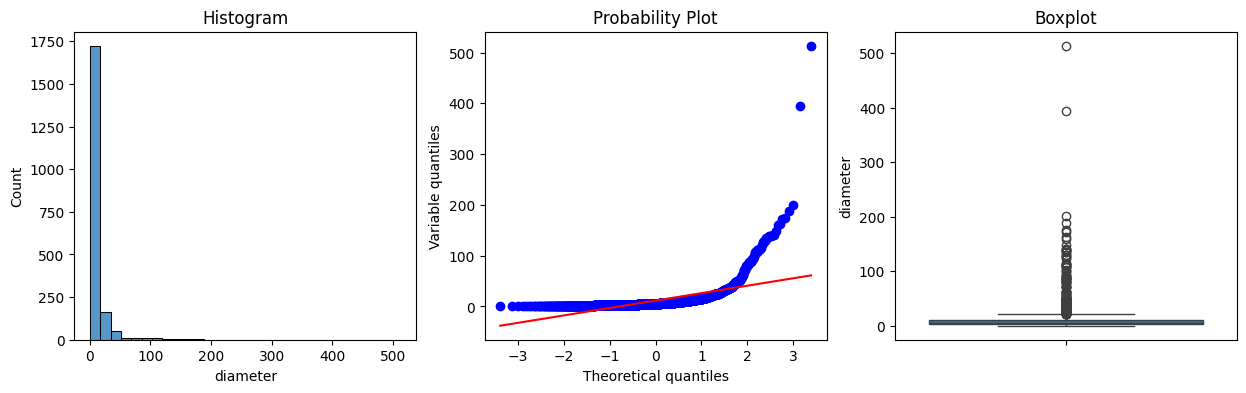

Аналіз змінної: H


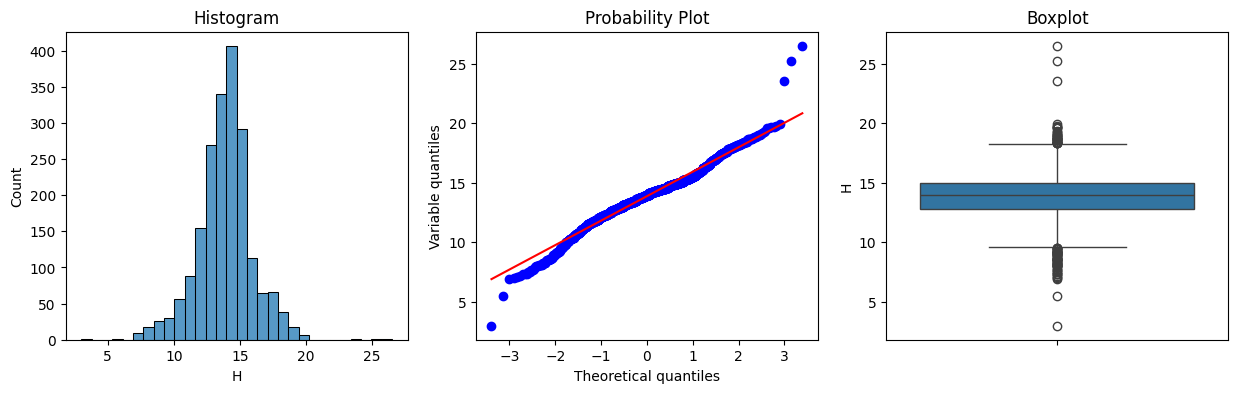

Аналіз змінної: albedo


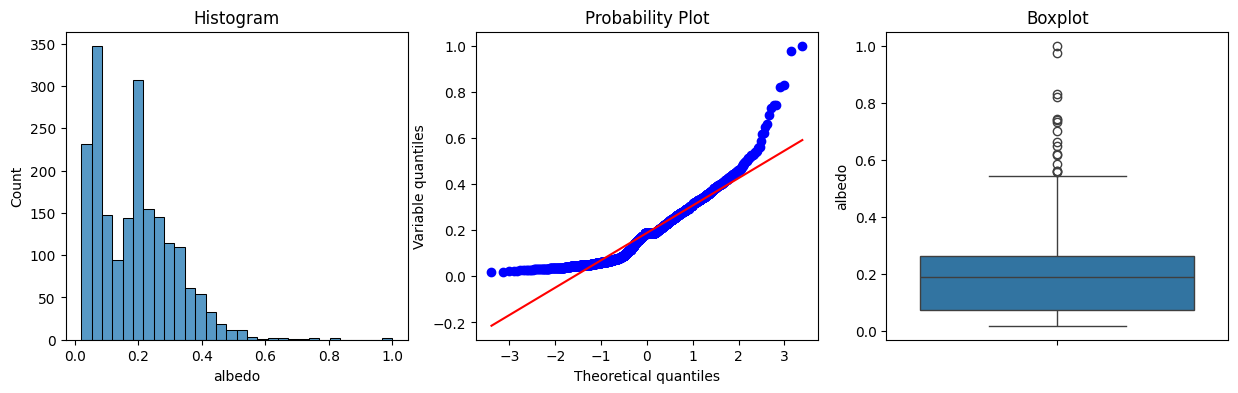

Аналіз змінної: e


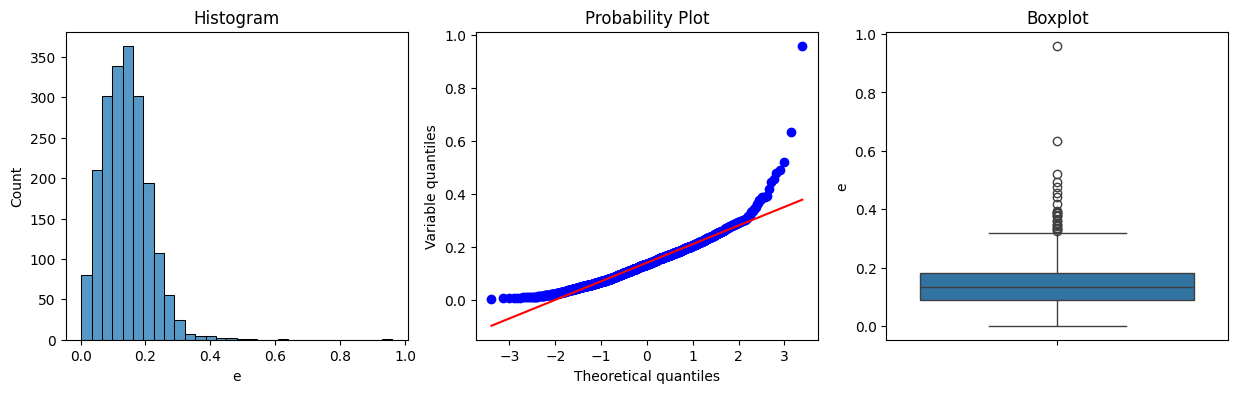

Аналіз змінної: a


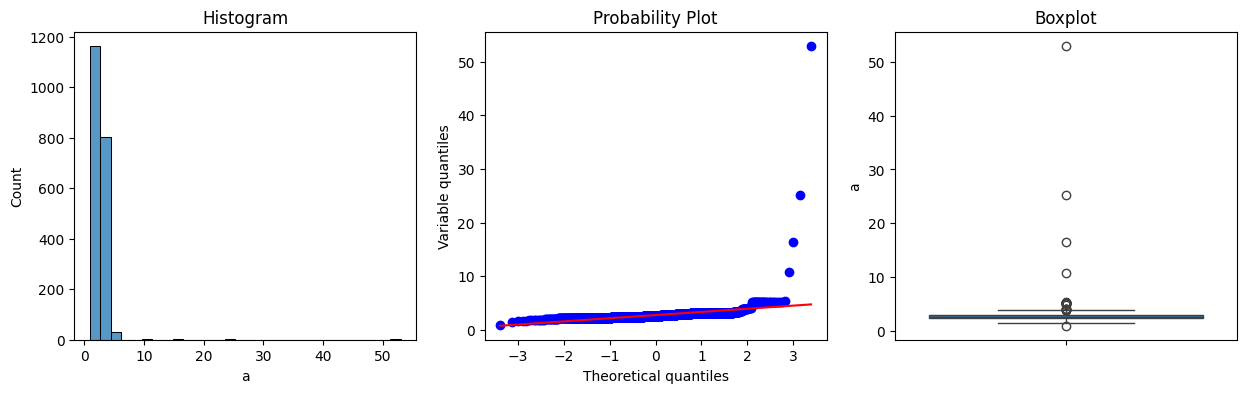

Аналіз змінної: q


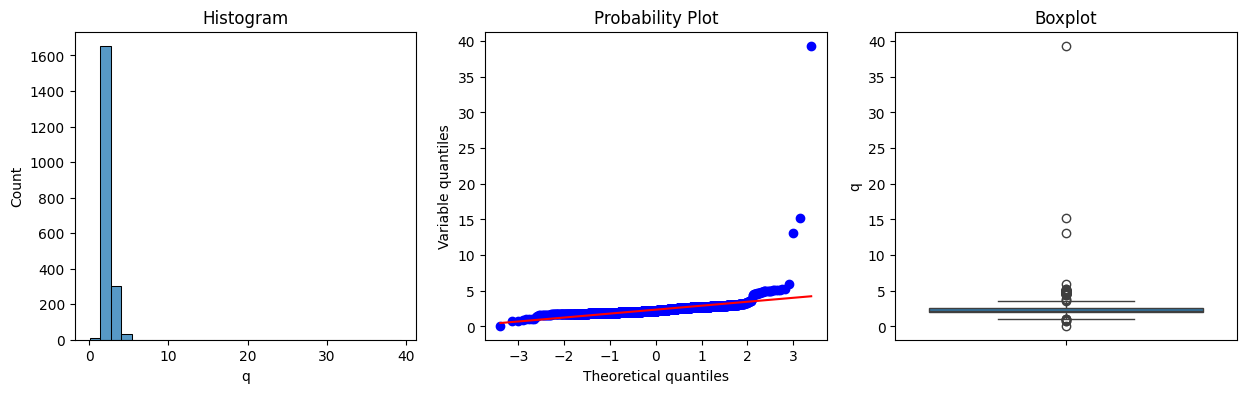

Аналіз змінної: i


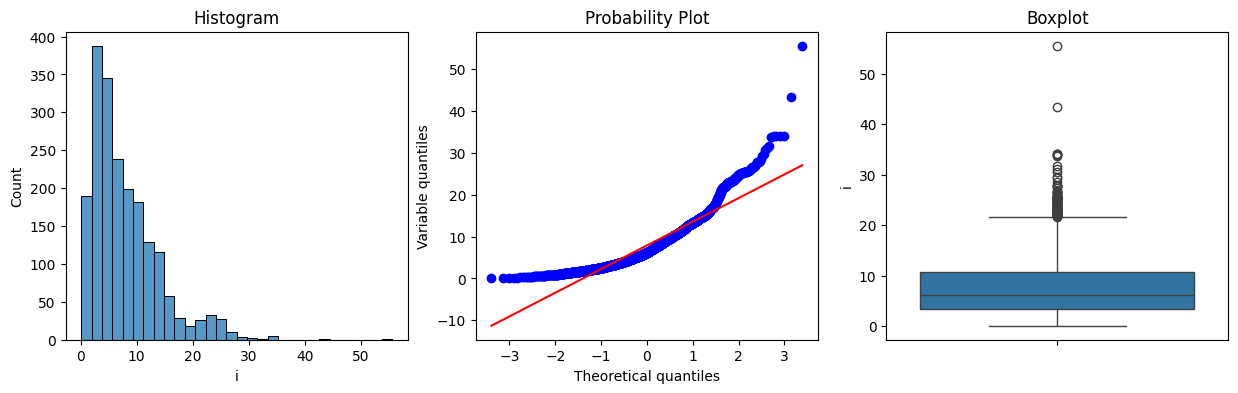

Аналіз змінної: ad


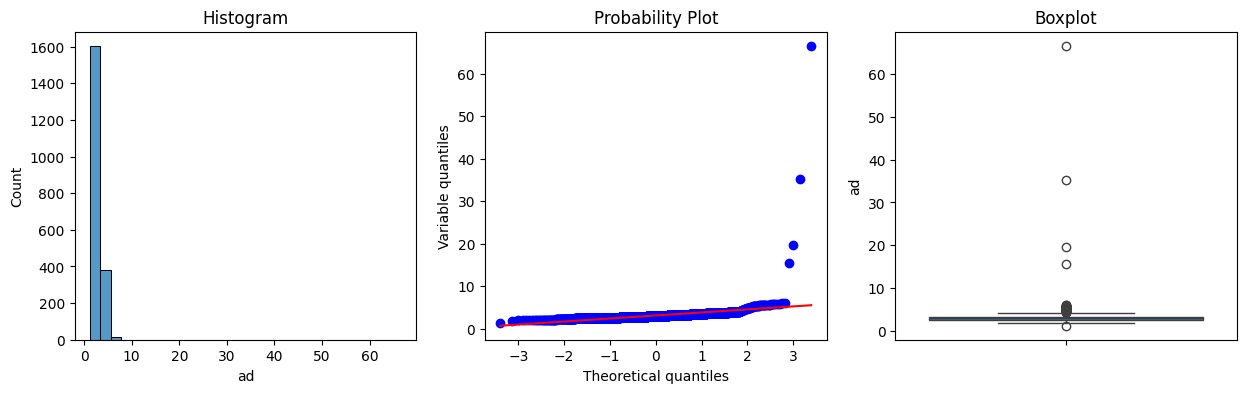

Аналіз змінної: moid


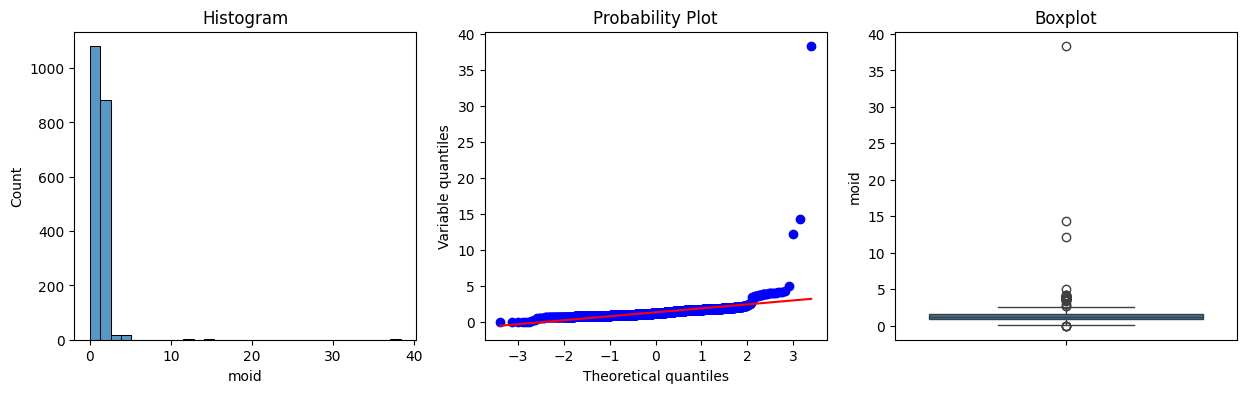

In [44]:
numerical_cols = ['diameter', 'H', 'albedo', 'e', 'a', 'q', 'i', 'ad', 'moid']

for col in numerical_cols:
    print(f"Аналіз змінної: {col}")
    diagnostic_plots(df, col)

=== Обробка 'diameter' ===
До обробки 'diameter':


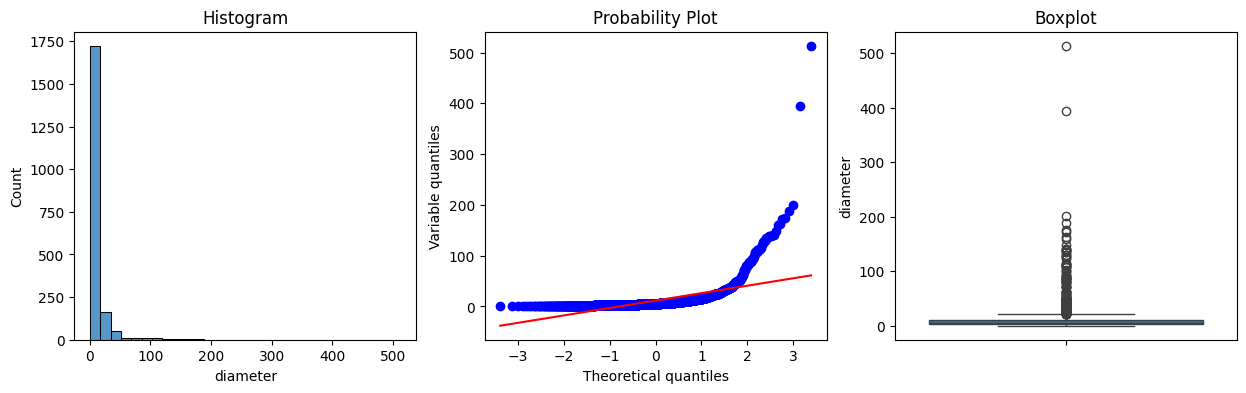

Верхня межа: 21.866890767374095, Нижня межа: -8.387037072379988
Після обробки 'diameter':


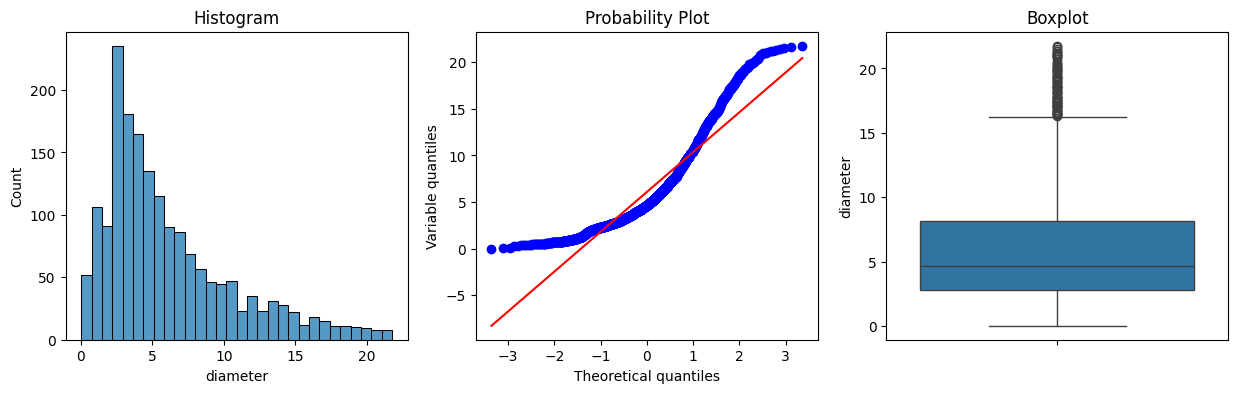

Розмір до: (2000, 44), Розмір після: (1784, 44)


=== Обробка 'H' ===
До обробки 'H':


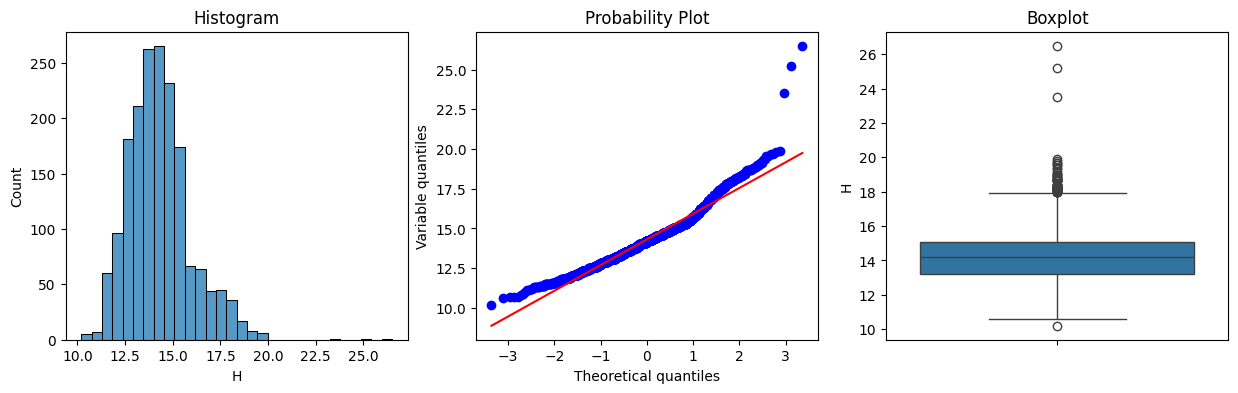

Верхня межа: 17.95, Нижня межа: 10.349999999999998
Після обробки 'H':


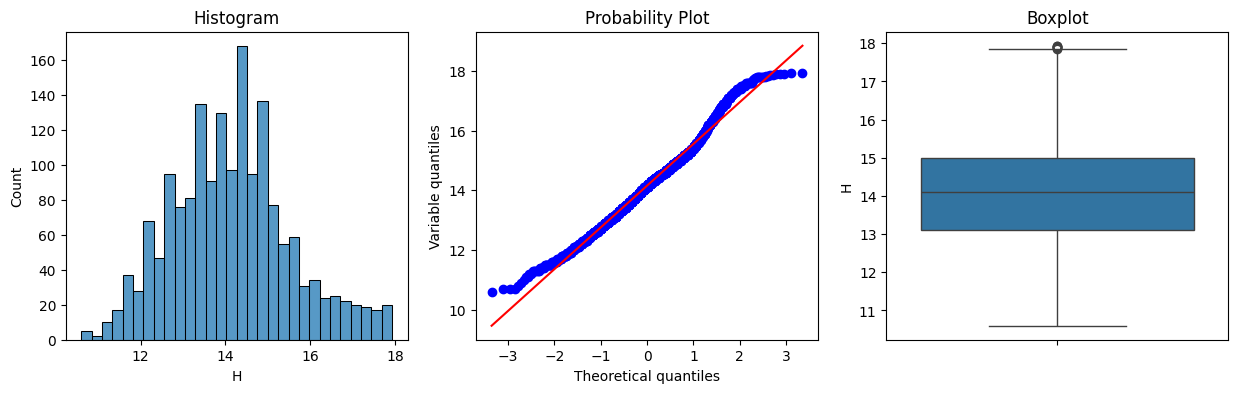

Розмір до: (1784, 44), Розмір після: (1722, 44)


=== Обробка 'albedo' ===
До обробки 'albedo':


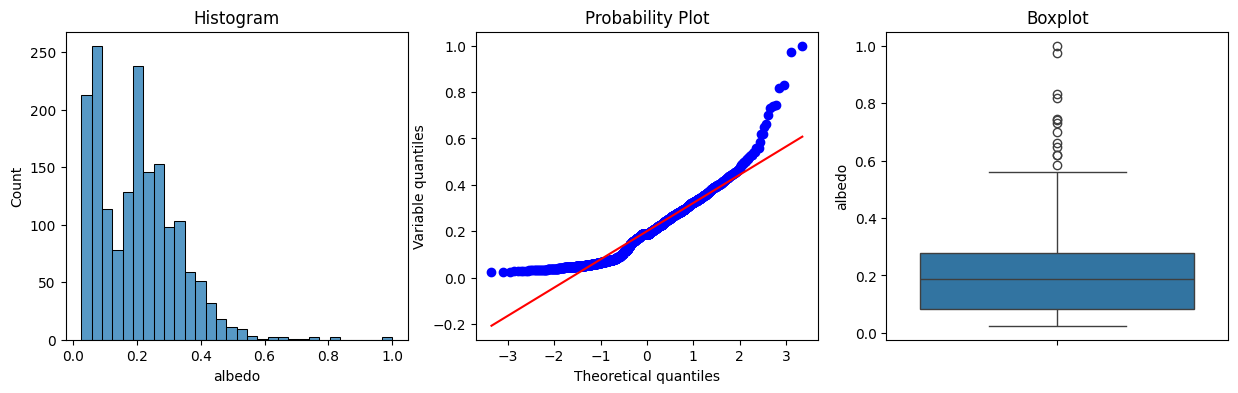

Верхня межа: 0.5720000000000001, Нижня межа: -0.21200000000000002
Після обробки 'albedo':


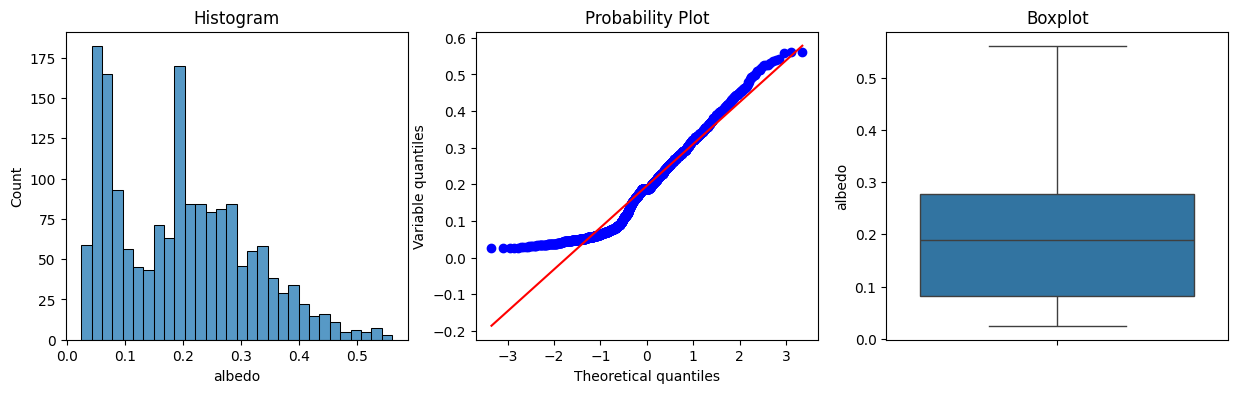

Розмір до: (1722, 44), Розмір після: (1709, 44)


=== Обробка 'e' ===
До обробки 'e':


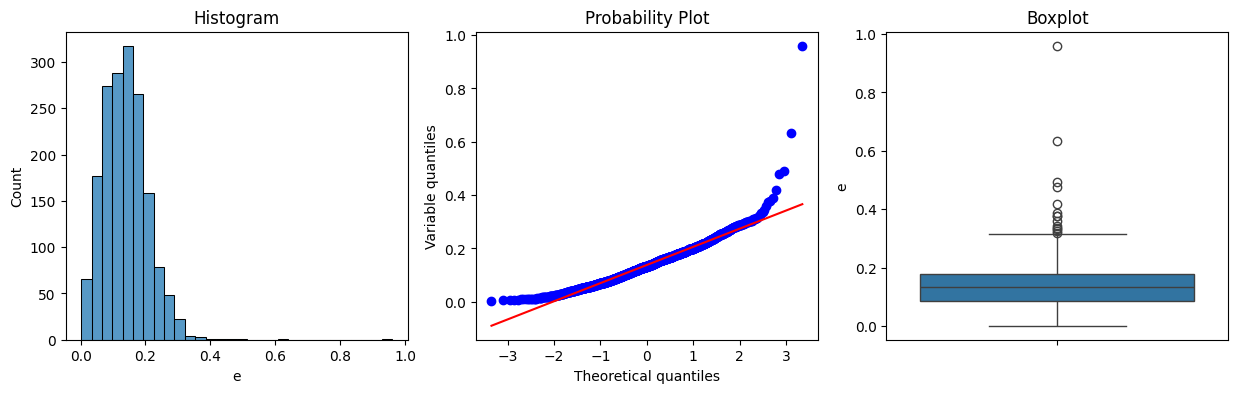

Верхня межа: 0.3166770527440635, Нижня межа: -0.050428400405459387
Після обробки 'e':


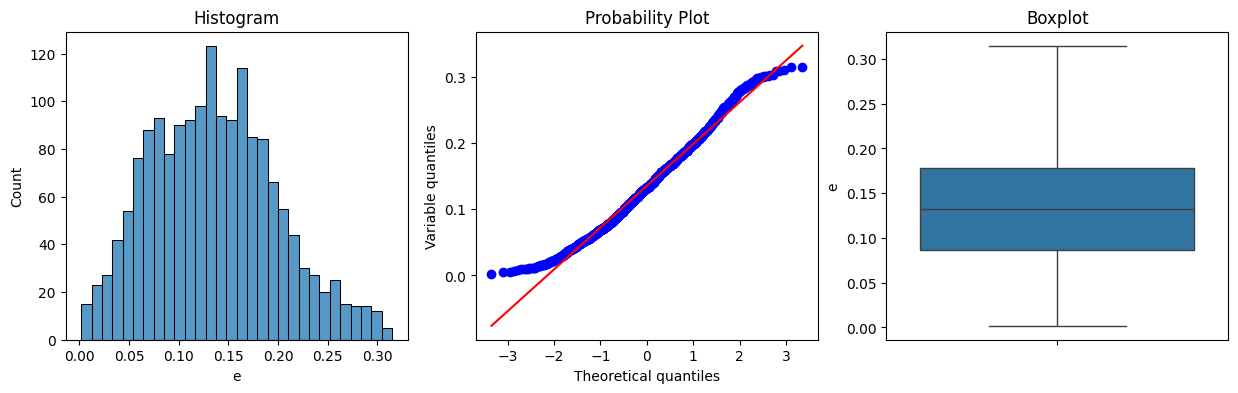

Розмір до: (1709, 44), Розмір після: (1695, 44)


=== Обробка 'a' ===
До обробки 'a':


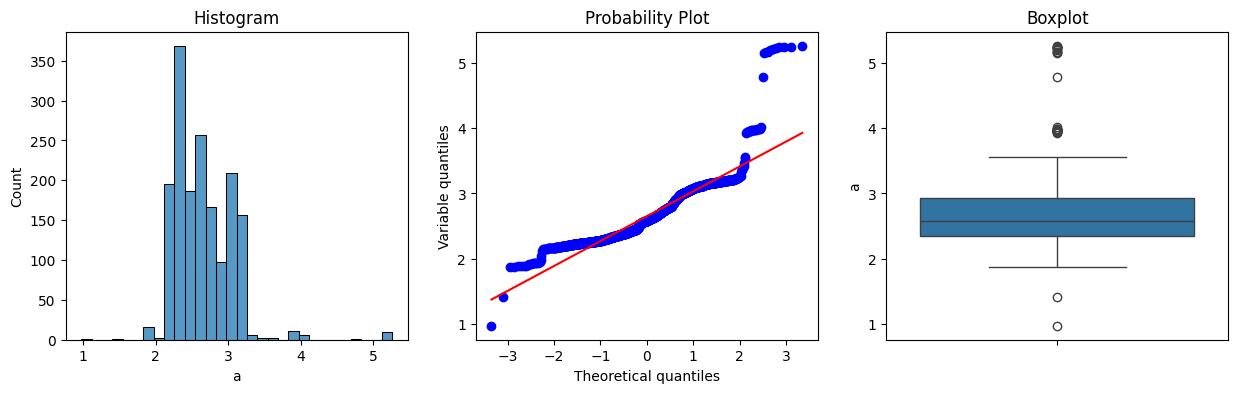

Верхня межа: 3.8211084687353027, Нижня межа: 1.4623018965802224
Після обробки 'a':


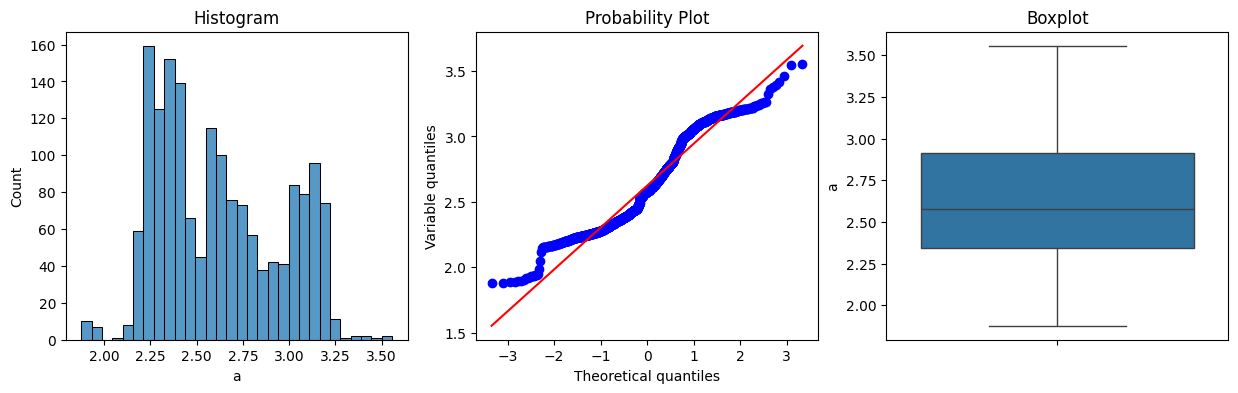

Розмір до: (1695, 44), Розмір після: (1665, 44)


=== Обробка 'q' ===
До обробки 'q':


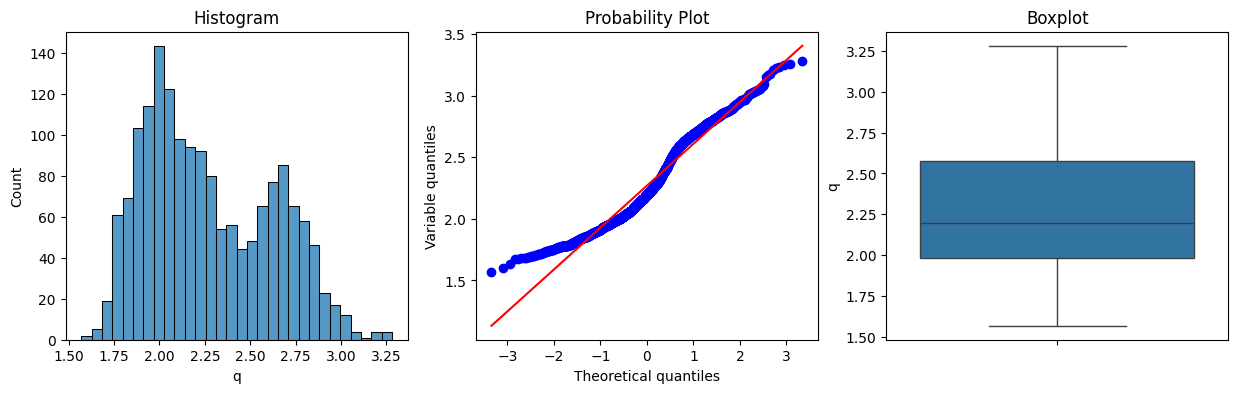

Верхня межа: 3.4704285310367826, Нижня межа: 1.0912025832712953
Після обробки 'q':


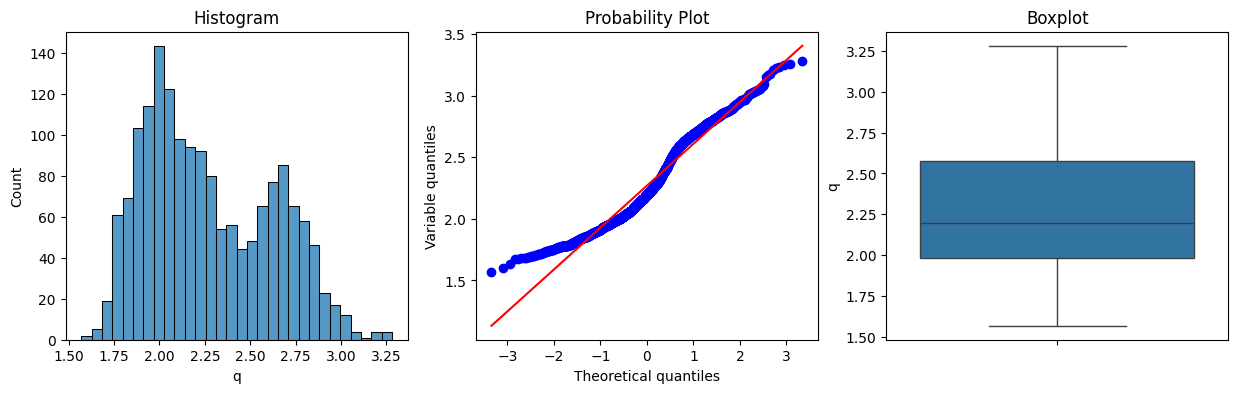

Розмір до: (1665, 44), Розмір після: (1665, 44)


=== Обробка 'i' ===
До обробки 'i':


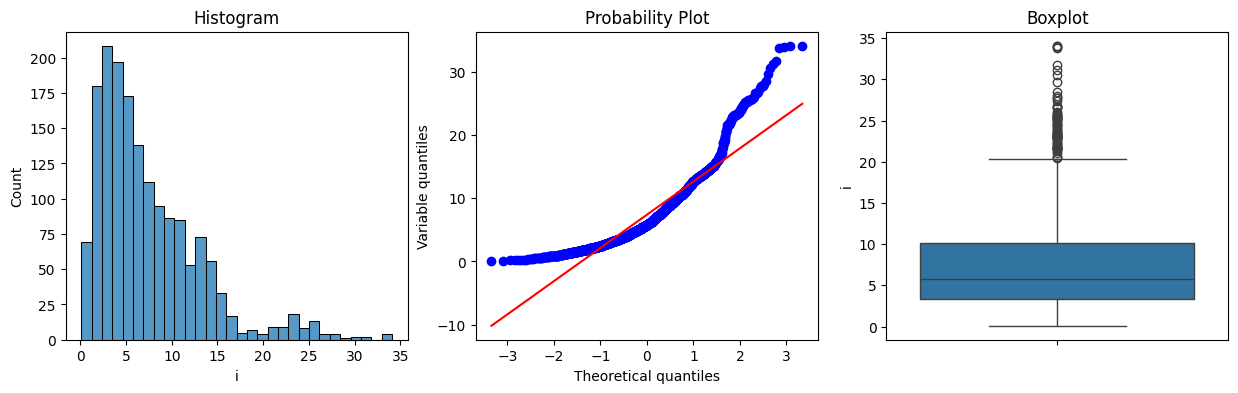

Верхня межа: 20.378094187063752, Нижня межа: -6.944426555050196
Після обробки 'i':


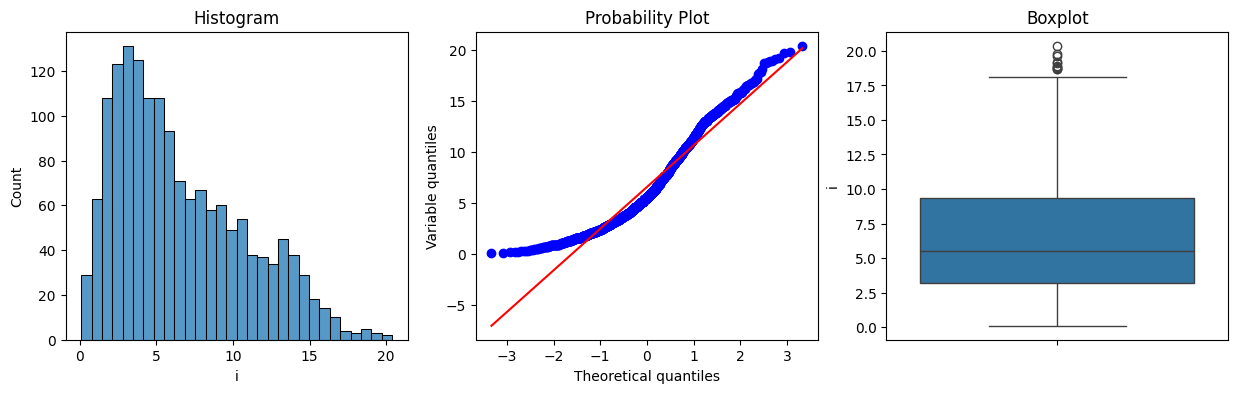

Розмір до: (1665, 44), Розмір після: (1590, 44)


=== Обробка 'ad' ===
До обробки 'ad':


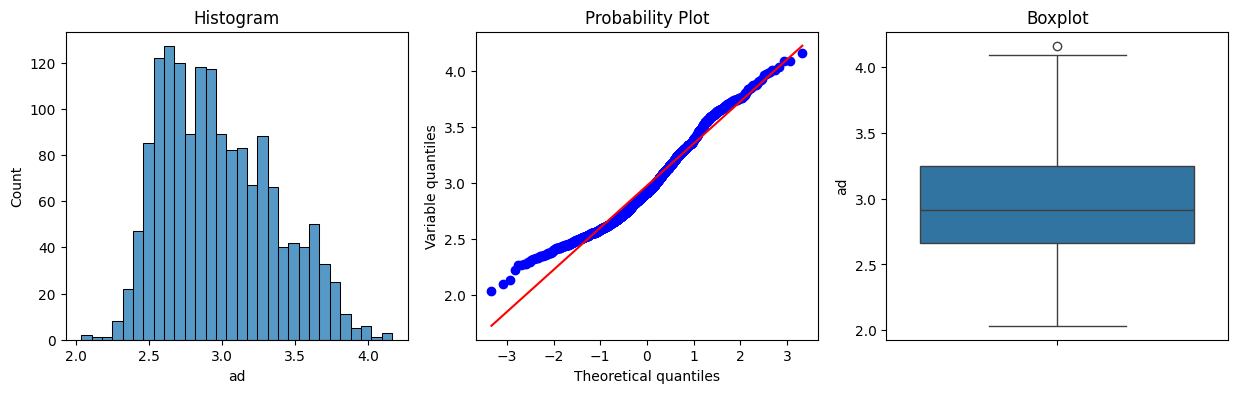

Верхня межа: 4.13355388094834, Нижня межа: 1.7811429971211303
Після обробки 'ad':


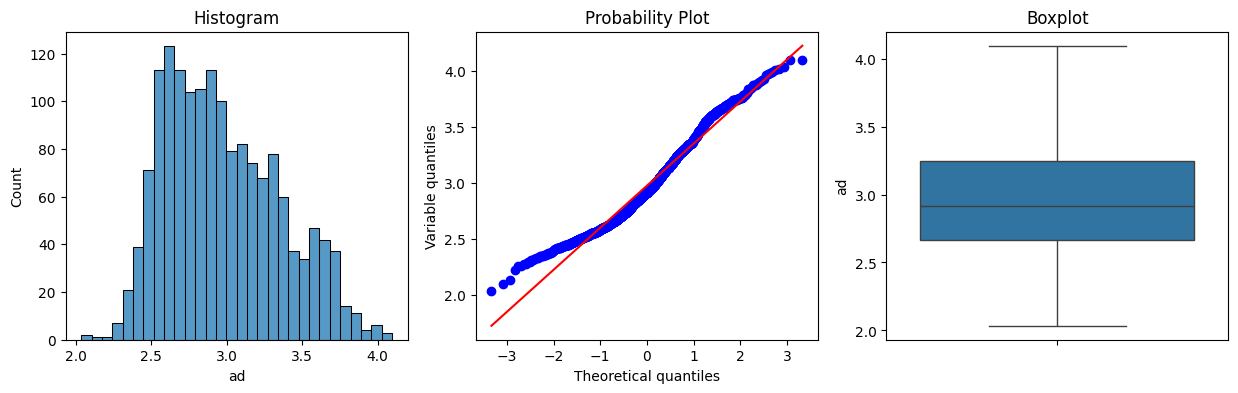

Розмір до: (1590, 44), Розмір після: (1589, 44)


=== Обробка 'moid' ===
До обробки 'moid':


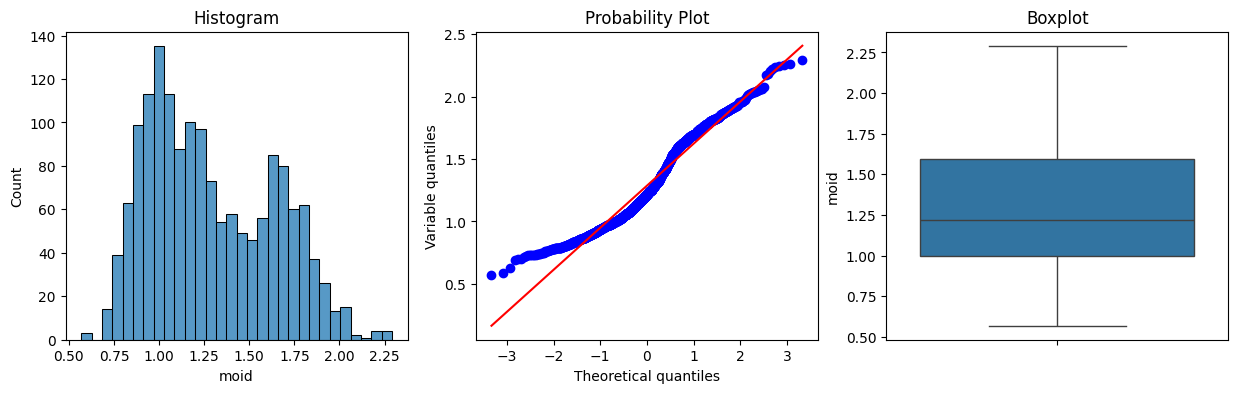

Верхня межа: 2.4886700000000004, Нижня межа: 0.1058699999999998
Після обробки 'moid':


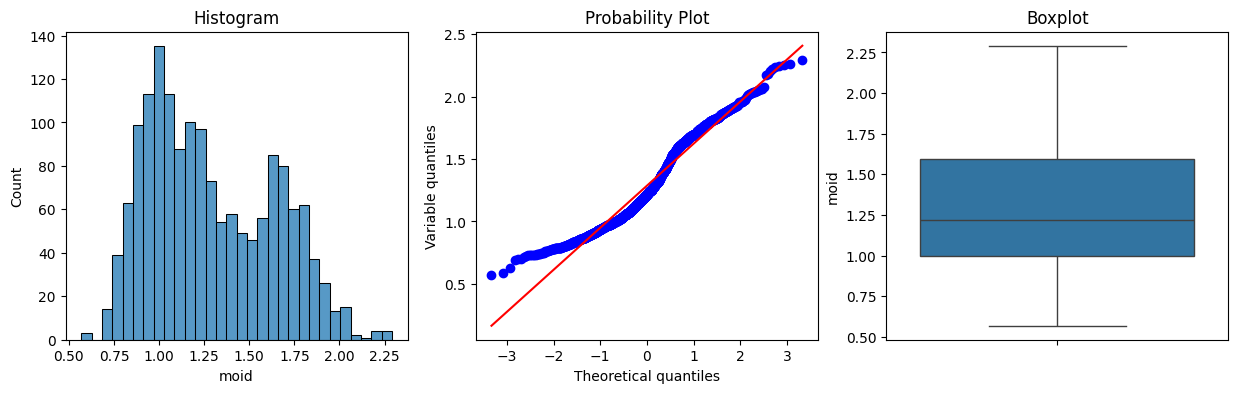

Розмір до: (1589, 44), Розмір після: (1589, 44)




In [45]:
# Функція для знаходження меж аномалій
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

# Змінні, які потребують перевірки на аномалії
variables_to_check = ['diameter', 'H', 'albedo', 'e', 'a', 'q', 'i', 'ad', 'moid']

# Цикл для кожної змінної
for variable in variables_to_check:
    print(f"=== Обробка '{variable}' ===")
    
    # Візуалізація до обробки
    print(f"До обробки '{variable}':")
    diagnostic_plots(df, variable)

    # Знаходимо межі для аномалій
    upper_limit, lower_limit = find_skewed_boundaries(df, variable, distance=1.5)
    print(f"Верхня межа: {upper_limit}, Нижня межа: {lower_limit}")

    # Виявляємо аномалії
    outliers = np.where(
        (df[variable] > upper_limit) | (df[variable] < lower_limit),
        True,
        False
    )

    # Видаляємо аномалії
    df_trimmed = df.loc[~outliers]

    # Візуалізація після обробки
    print(f"Після обробки '{variable}':")
    diagnostic_plots(df_trimmed, variable)

    # Перевірка розміру набору даних
    print(f"Розмір до: {df.shape}, Розмір після: {df_trimmed.shape}")
    print("\n")
    
    # Оновлюємо основний DataFrame
    df = df_trimmed

## Масштабування значень ознак

In [46]:
df.describe()

,spkid,pha,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,1.589000e+03,1589.0,1589.000000,1589.000000,1589.000000,1424.000000,1.589000e+03,1589.000000,1.589000e+03,1589.000000,...,1.585000e+03,1585.000000,1585.000000,1585.000000,1585.000000,1.585000e+03,1.585000e+03,1585.000000,1585.000000,1589.000000
mean,2.207463e+06,0.0,14.161806,6.223395,0.198410,0.353836,2.458990e+06,58989.887351,2.020026e+07,0.133371,...,1.590556e-02,0.019029,0.062567,4.743846,4.778652,1.032505e-02,1.261256e-03,17.690110,8.090969,0.504364
std,2.279081e+06,0.0,1.405067,4.429714,0.116333,0.514445,2.072491e+02,207.249094,5.645523e+03,0.061181,...,4.736703e-01,0.462716,1.915055,151.661907,146.781288,3.622041e-01,4.400606e-02,599.072502,280.821158,0.058723
min,2.000262e+06,0.0,10.600000,0.792669,0.026000,0.017000,2.452534e+06,52533.000000,2.002092e+07,0.005347,...,5.242100e-08,0.000003,0.000011,0.000014,0.000005,4.510000e-09,7.932600e-10,0.000020,0.000003,0.208880
25%,2.006158e+06,0.0,13.100000,2.931884,0.085000,0.121000,2.459000e+06,59000.000000,2.020053e+07,0.085974,...,8.287600e-08,0.000004,0.000027,0.000036,0.000013,9.120700e-09,1.341100e-09,0.000054,0.000007,0.465680
50%,2.013993e+06,0.0,14.100000,4.803958,0.188307,0.206500,2.459000e+06,59000.000000,2.020053e+07,0.131807,...,1.018200e-07,0.000004,0.000043,0.000053,0.000019,1.288900e-08,1.494400e-09,0.000080,0.000010,0.503510
75%,2.030040e+06,0.0,15.000000,8.218319,0.277000,0.376750,2.459000e+06,59000.000000,2.020053e+07,0.174250,...,1.260100e-07,0.000005,0.000077,0.000089,0.000031,1.887000e-08,1.781400e-09,0.000138,0.000016,0.536920
max,5.401596e+07,0.0,17.935000,21.766346,0.561000,7.185000,2.459000e+06,59000.000000,2.020053e+07,0.314781,...,1.775600e+01,14.874000,71.797000,5790.200000,5456.800000,1.430100e+01,1.735700e+00,23429.000000,11064.000000,0.818360


Масштабування для 'diameter':


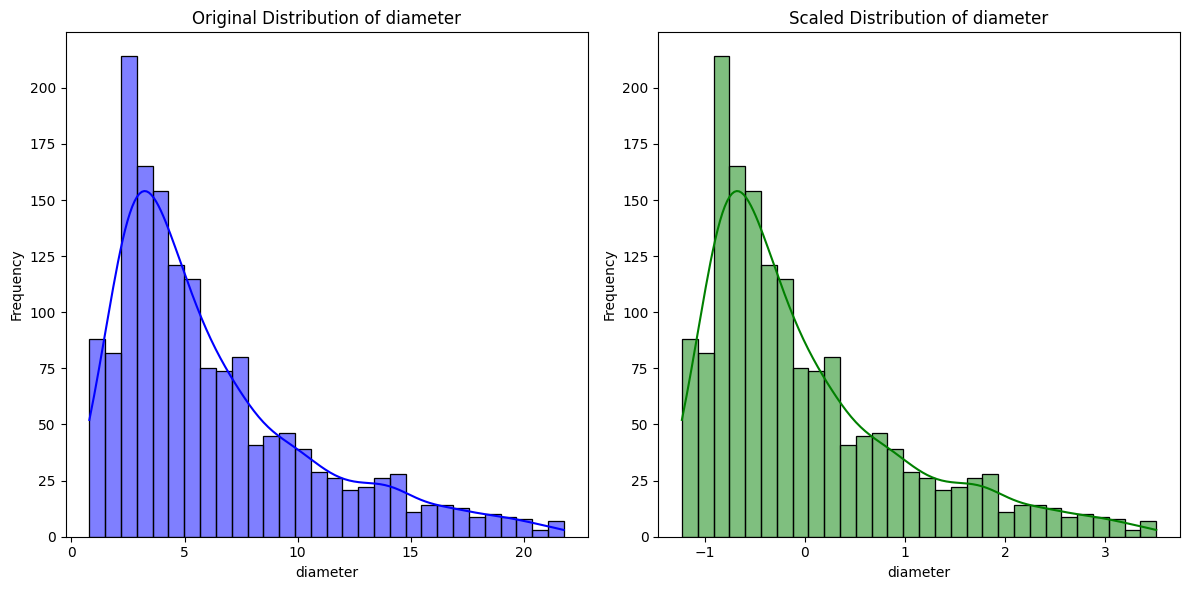

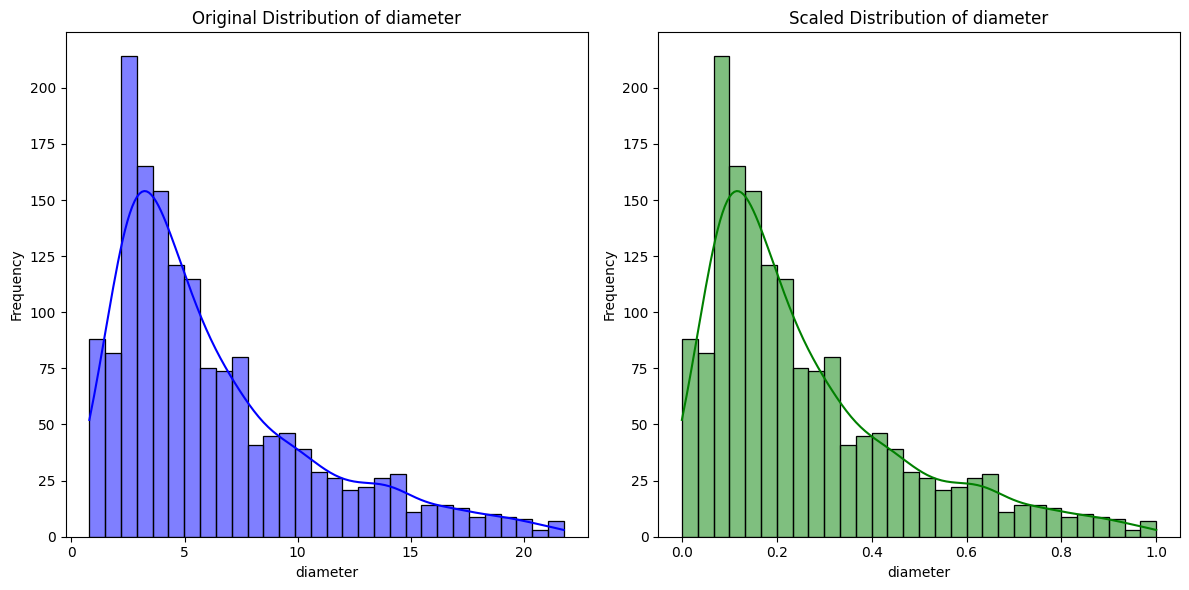

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Вибір числових колонок для масштабування
numerical_features = [
    'diameter', 'H', 'albedo', 'moid', 'a', 'e', 'i', 'om', 'w', 
    'ad', 'n', 'tp', 'per', 'rms'
]

# 1. Масштабування за допомогою StandardScaler (нормалізація)
standard_scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[numerical_features] = standard_scaler.fit_transform(df_standard_scaled[numerical_features])

# 2. Масштабування за допомогою MinMaxScaler (перетворення в діапазон [0, 1])
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numerical_features] = minmax_scaler.fit_transform(df_minmax_scaled[numerical_features])

# 3. Перевірка результатів: гістограми після масштабування
import matplotlib.pyplot as plt

def plot_scaled_features(df_original, df_scaled, feature):
    plt.figure(figsize=(12, 6))

    # Оригінальний розподіл
    plt.subplot(1, 2, 1)
    sns.histplot(df_original[feature], bins=30, kde=True, color='blue')
    plt.title(f'Original Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Масштабований розподіл
    plt.subplot(1, 2, 2)
    sns.histplot(df_scaled[feature], bins=30, kde=True, color='green')
    plt.title(f'Scaled Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Приклад перевірки для 'diameter'
print("Масштабування для 'diameter':")
plot_scaled_features(df, df_standard_scaled, 'diameter')
plot_scaled_features(df, df_minmax_scaled, 'diameter')

Масштабування для 'diameter' (StandardScaler):


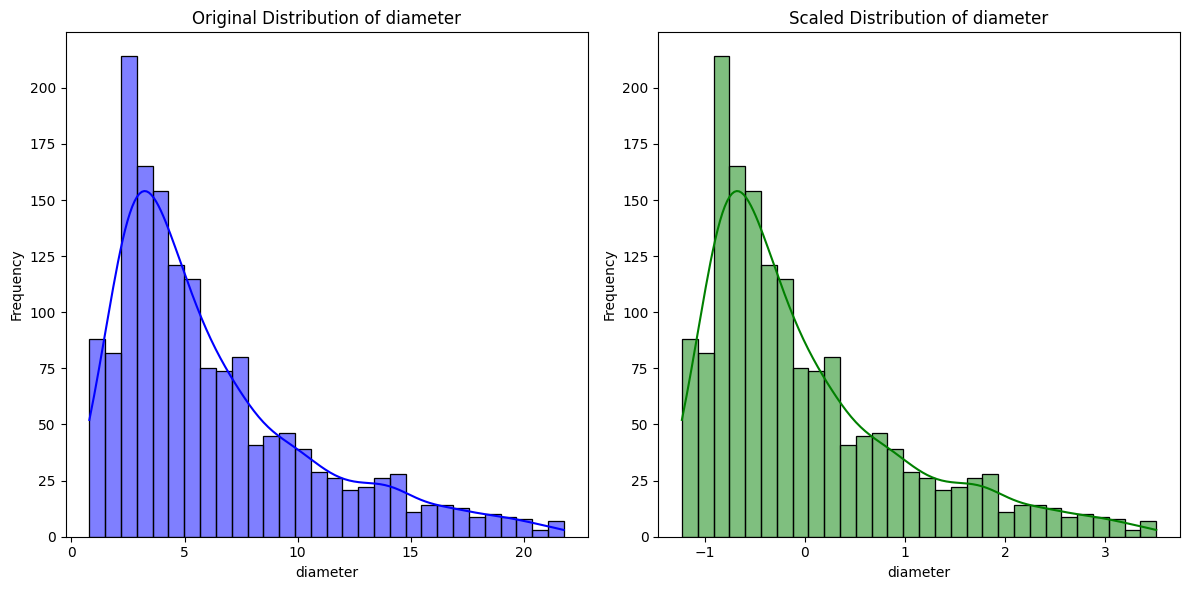

Масштабування для 'diameter' (MinMaxScaler):


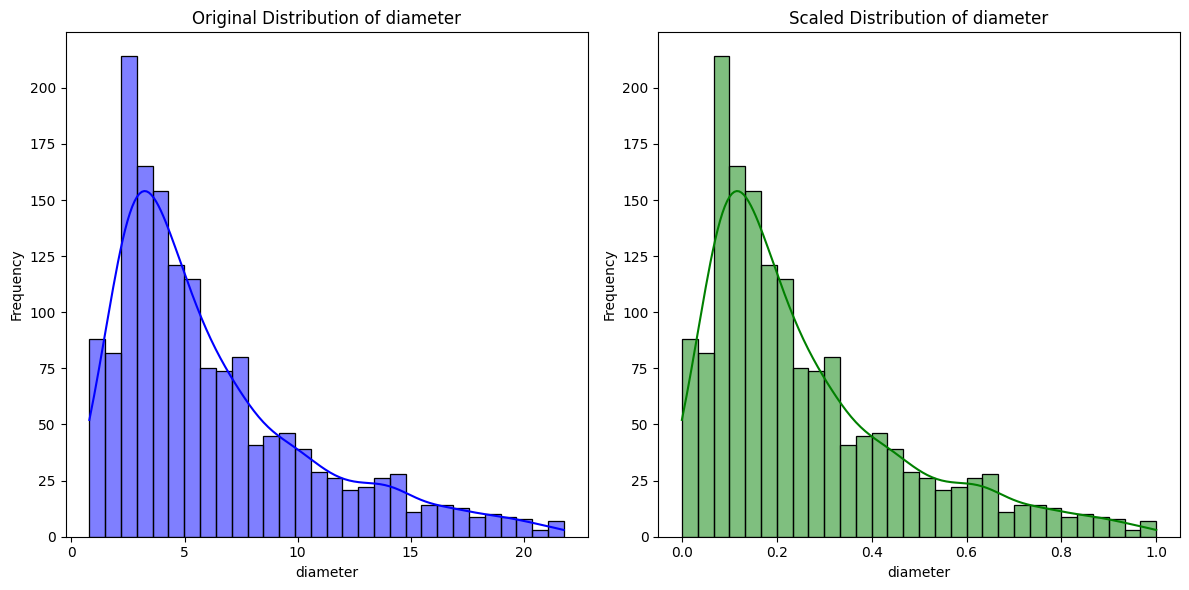

Масштабування для 'H' (StandardScaler):


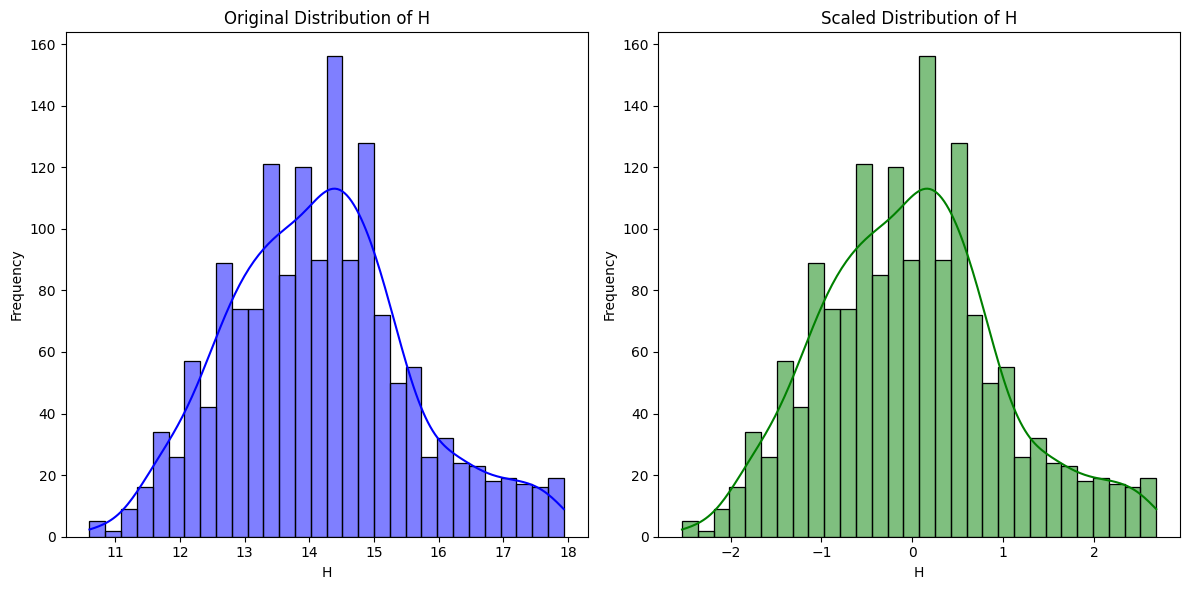

Масштабування для 'H' (MinMaxScaler):


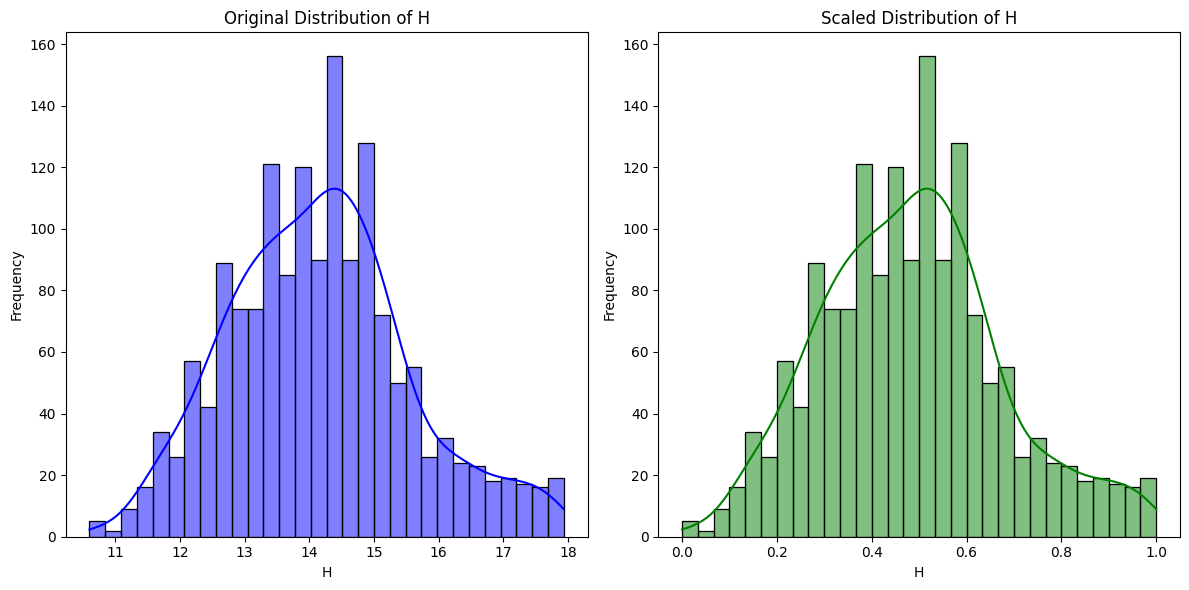

Масштабування для 'albedo' (StandardScaler):


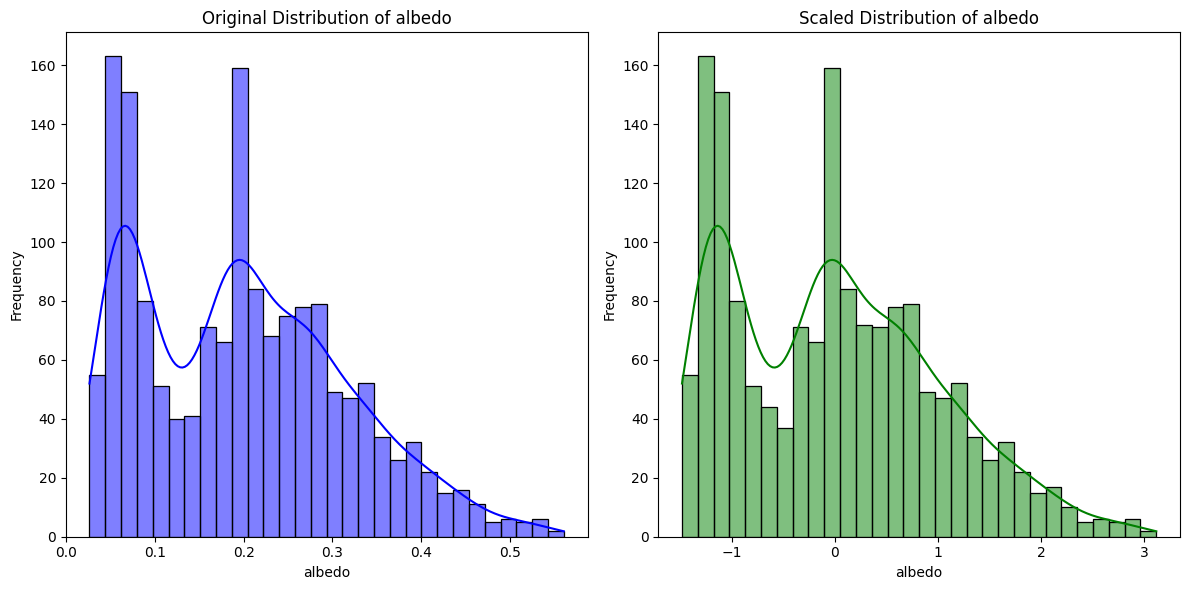

Масштабування для 'albedo' (MinMaxScaler):


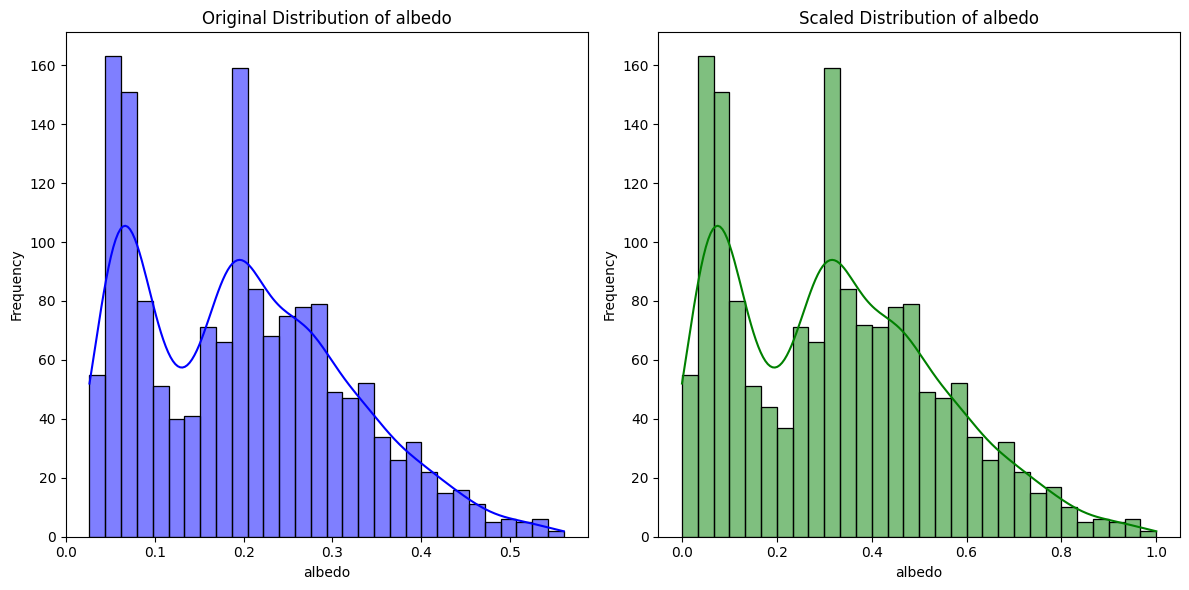

Масштабування для 'moid' (StandardScaler):


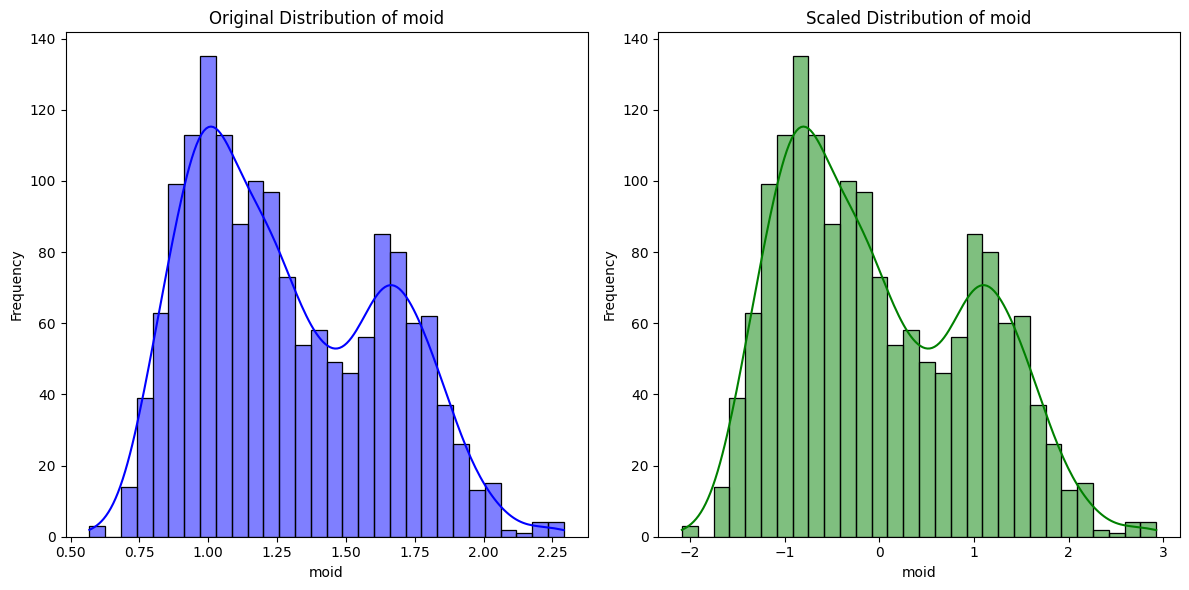

Масштабування для 'moid' (MinMaxScaler):


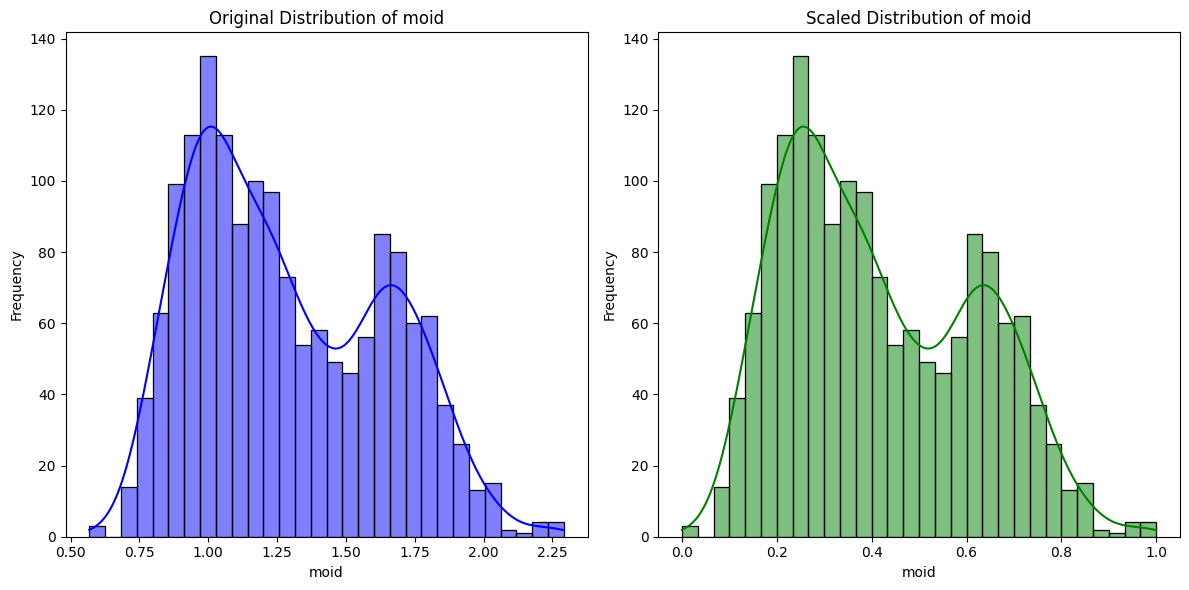

Масштабування для 'a' (StandardScaler):


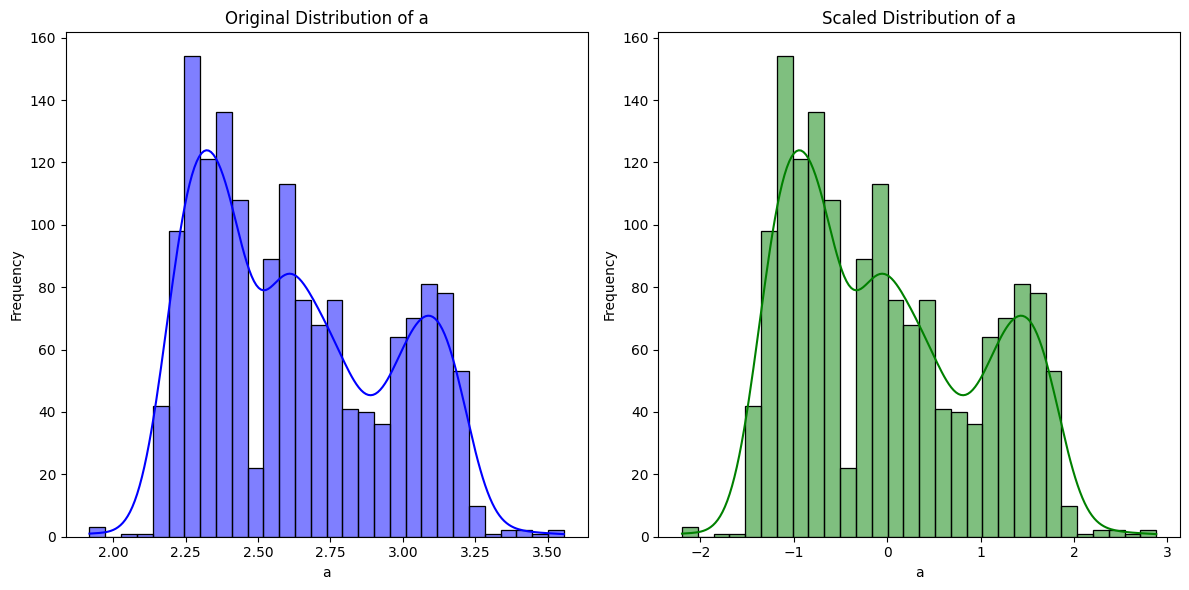

Масштабування для 'a' (MinMaxScaler):


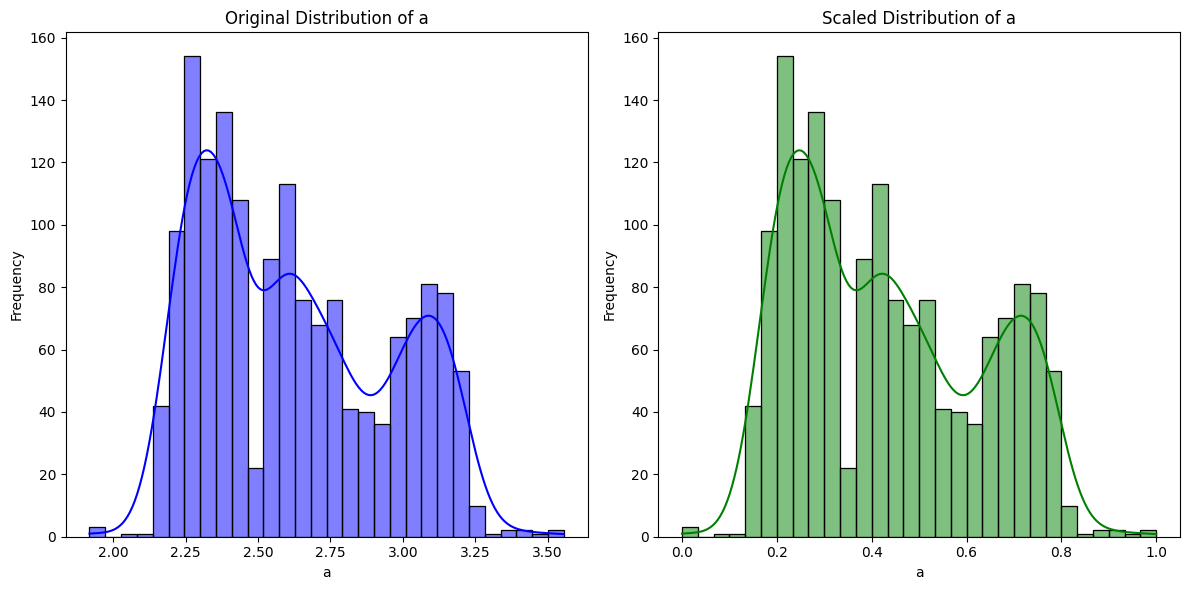

Масштабування для 'e' (StandardScaler):


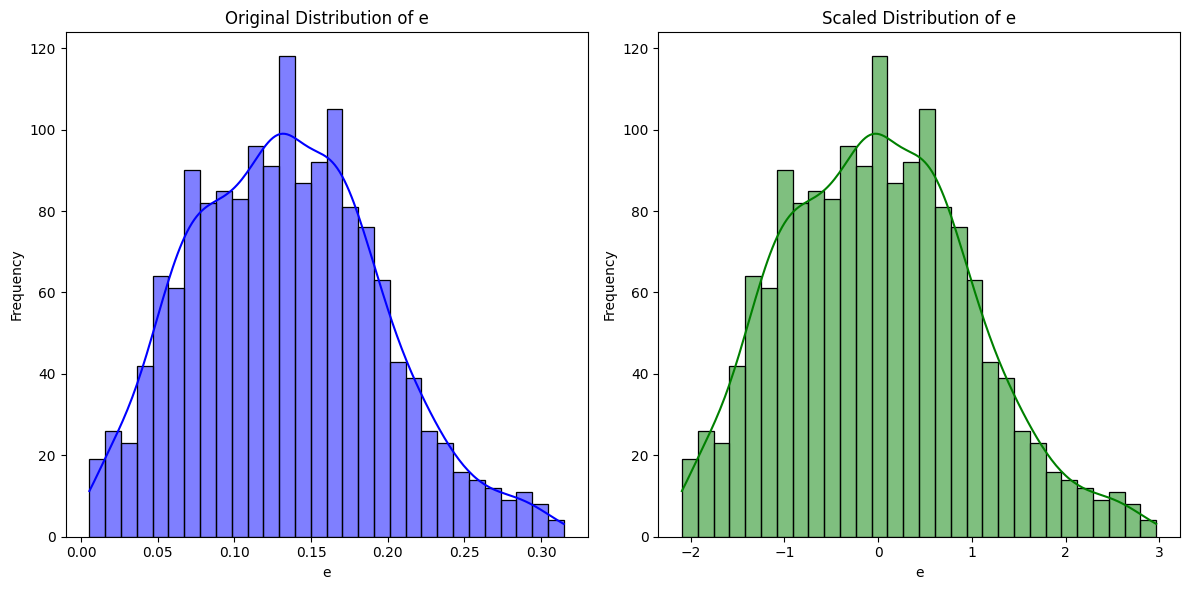

Масштабування для 'e' (MinMaxScaler):


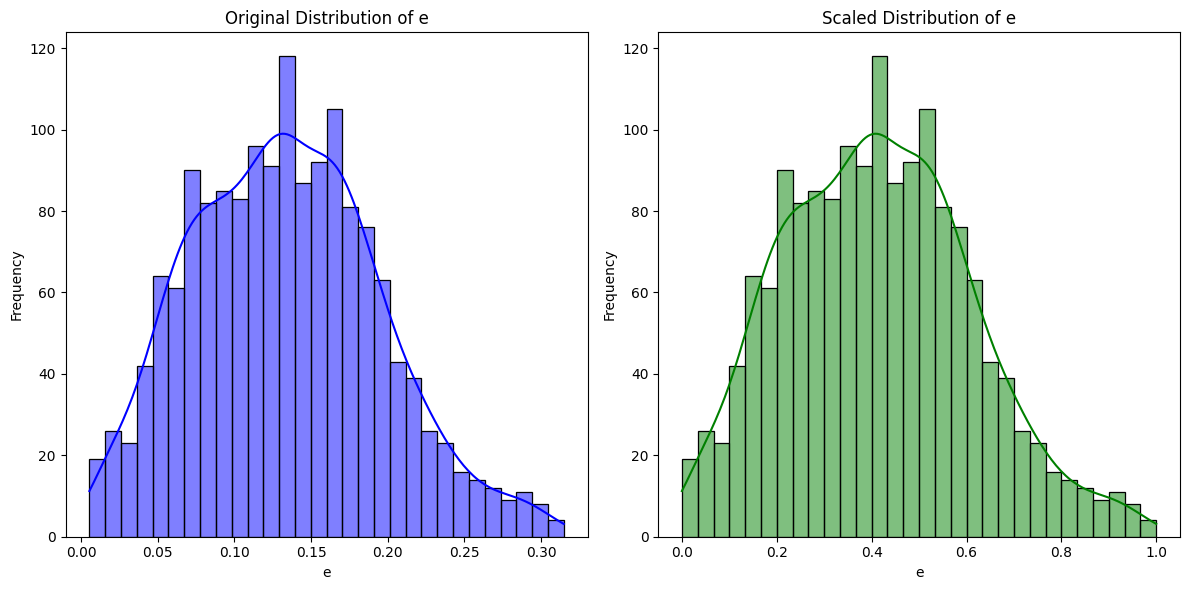

Масштабування для 'i' (StandardScaler):


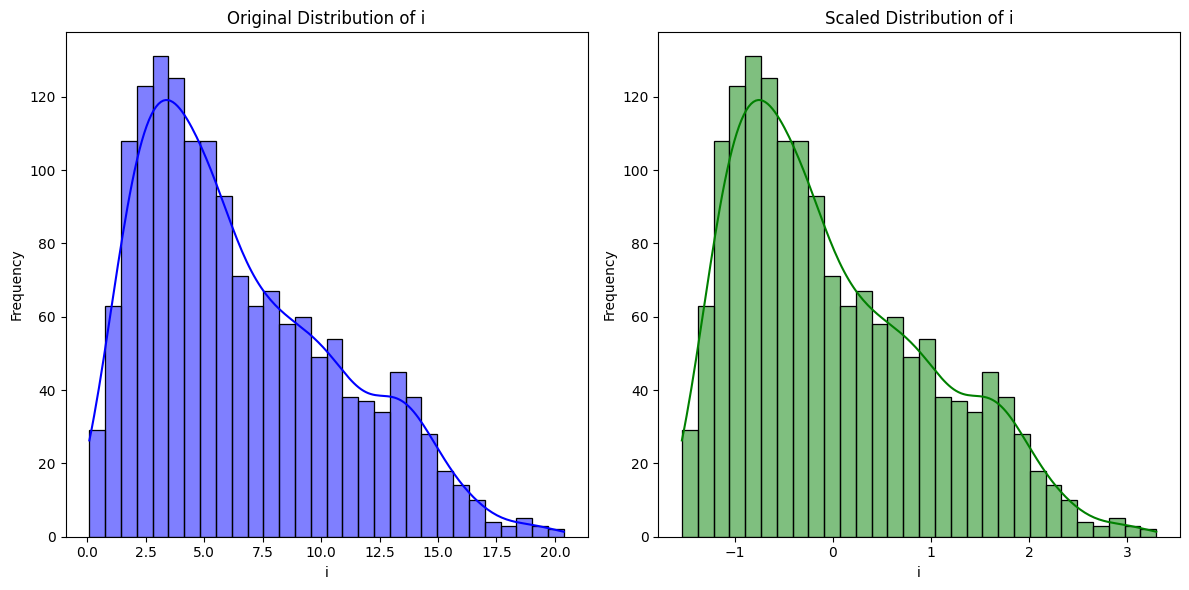

Масштабування для 'i' (MinMaxScaler):


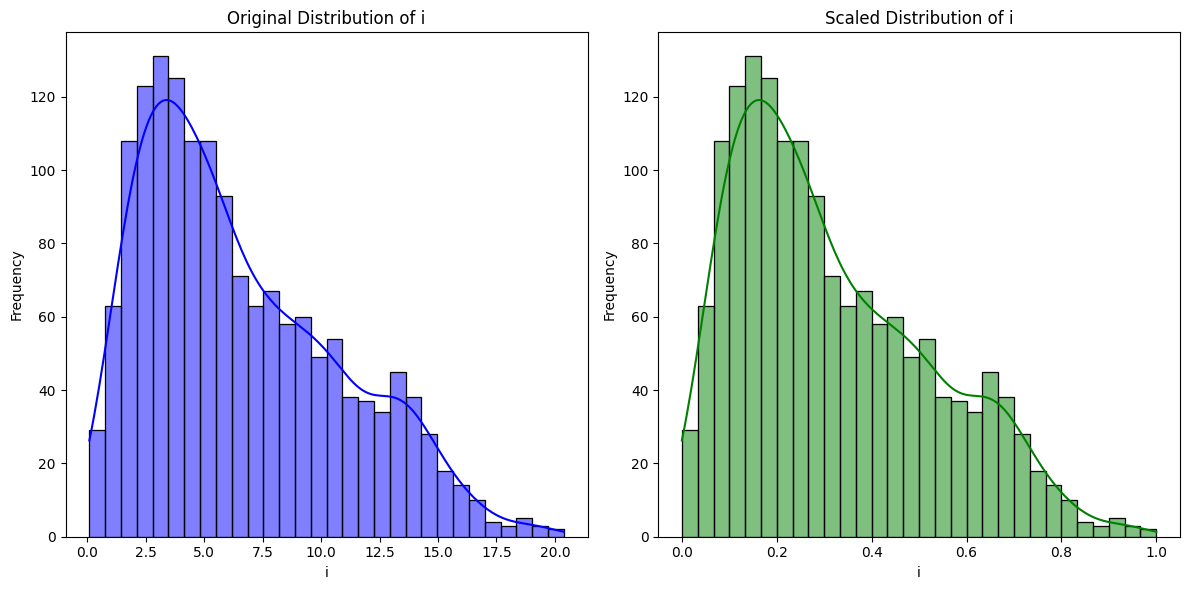

Масштабування для 'om' (StandardScaler):


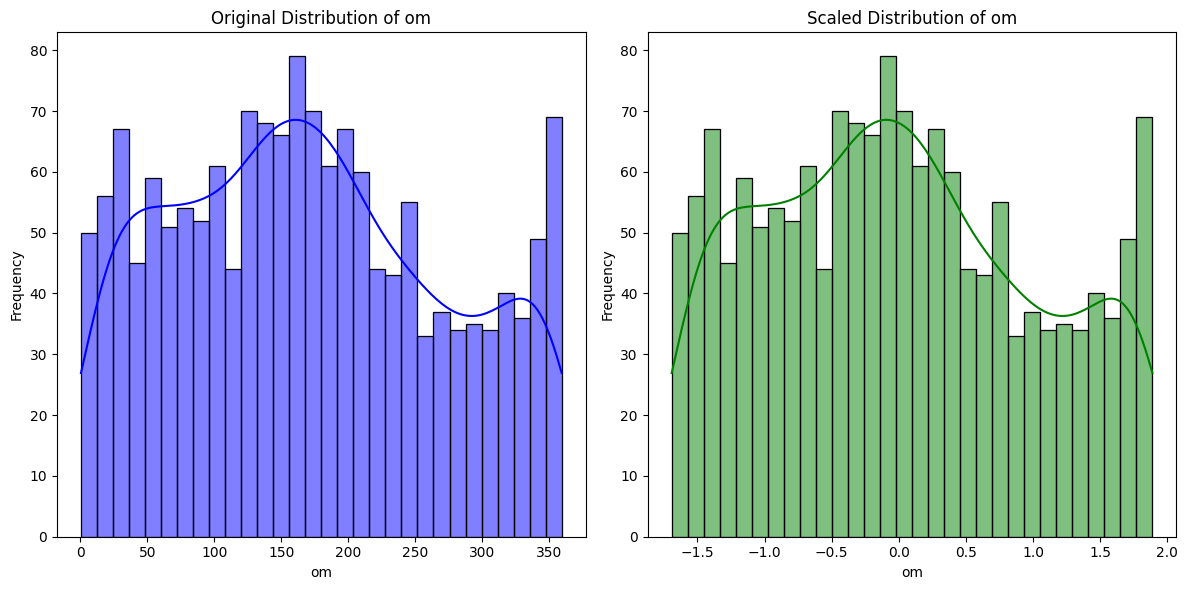

Масштабування для 'om' (MinMaxScaler):


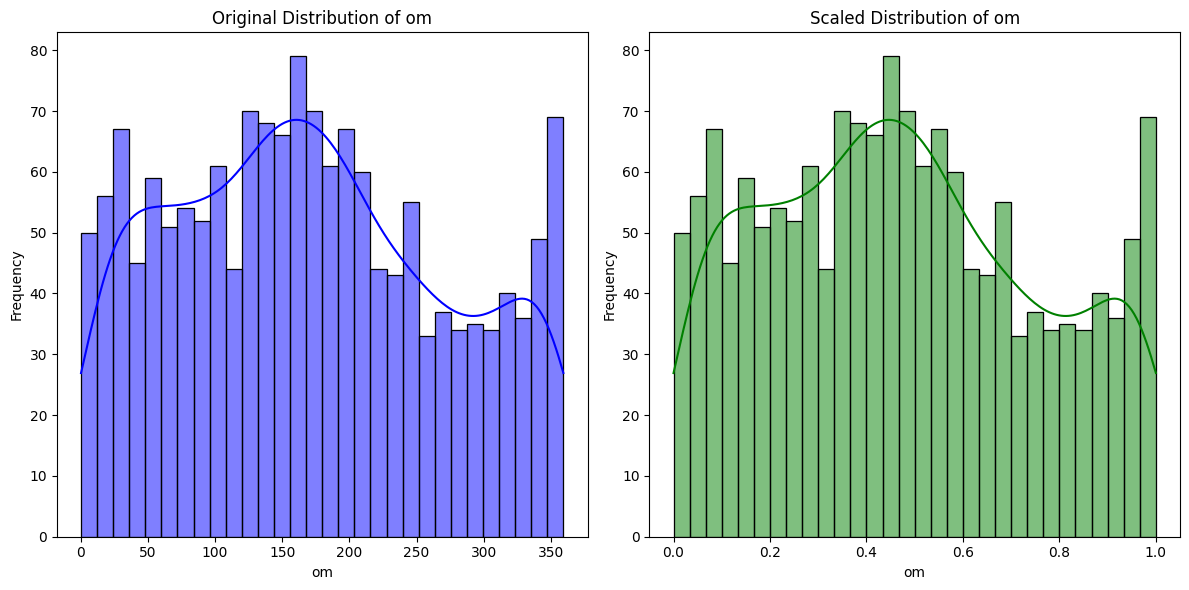

Масштабування для 'w' (StandardScaler):


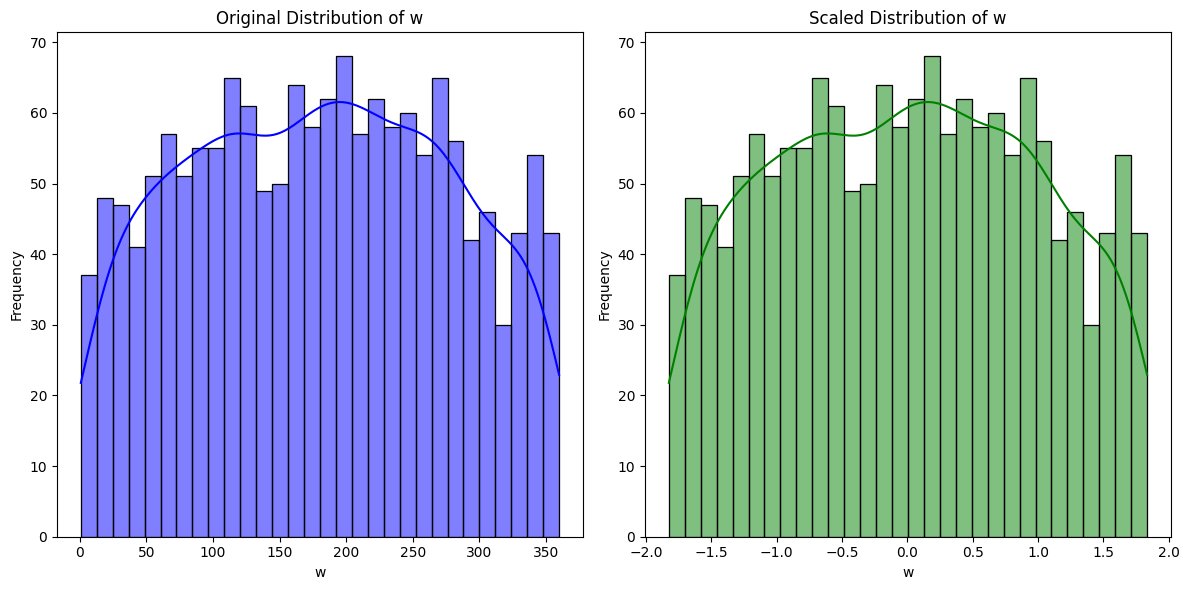

Масштабування для 'w' (MinMaxScaler):


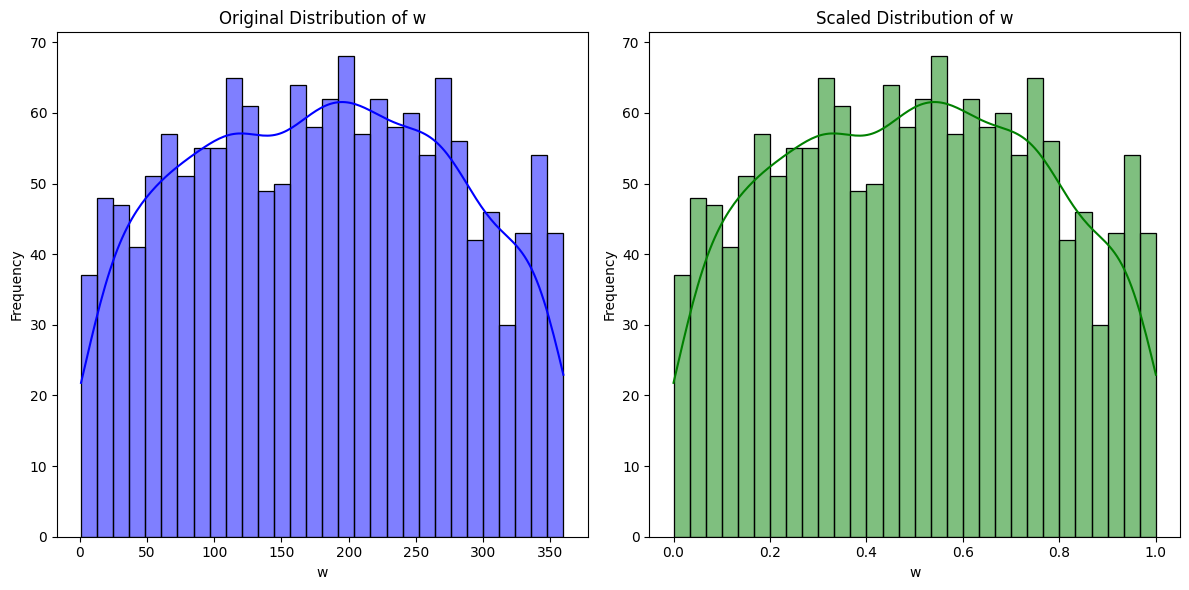

Масштабування для 'ad' (StandardScaler):


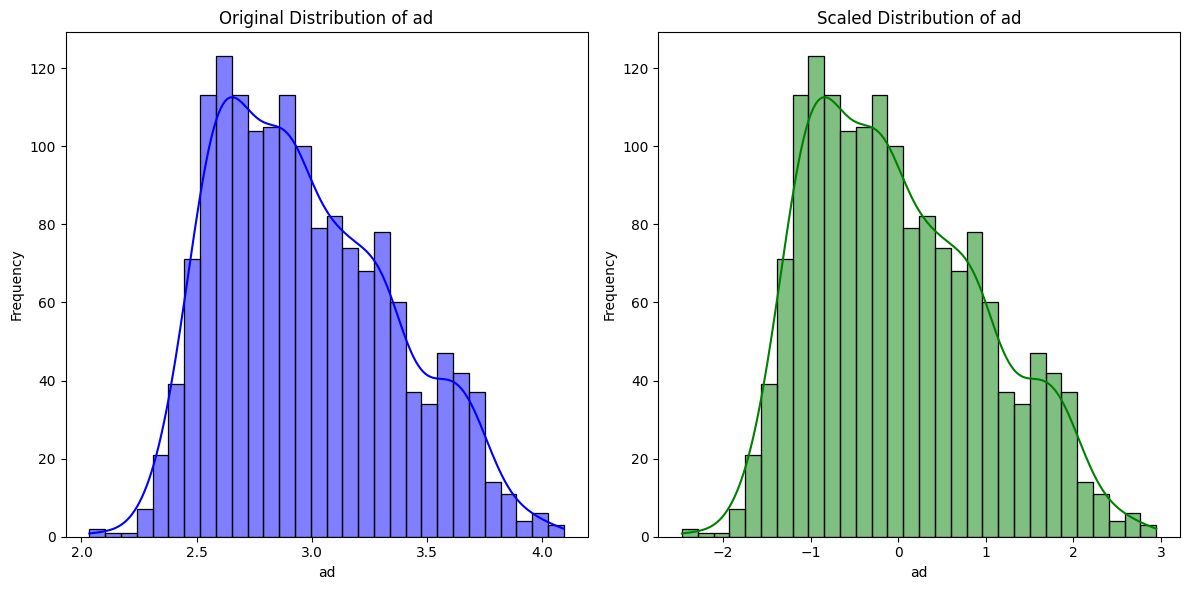

Масштабування для 'ad' (MinMaxScaler):


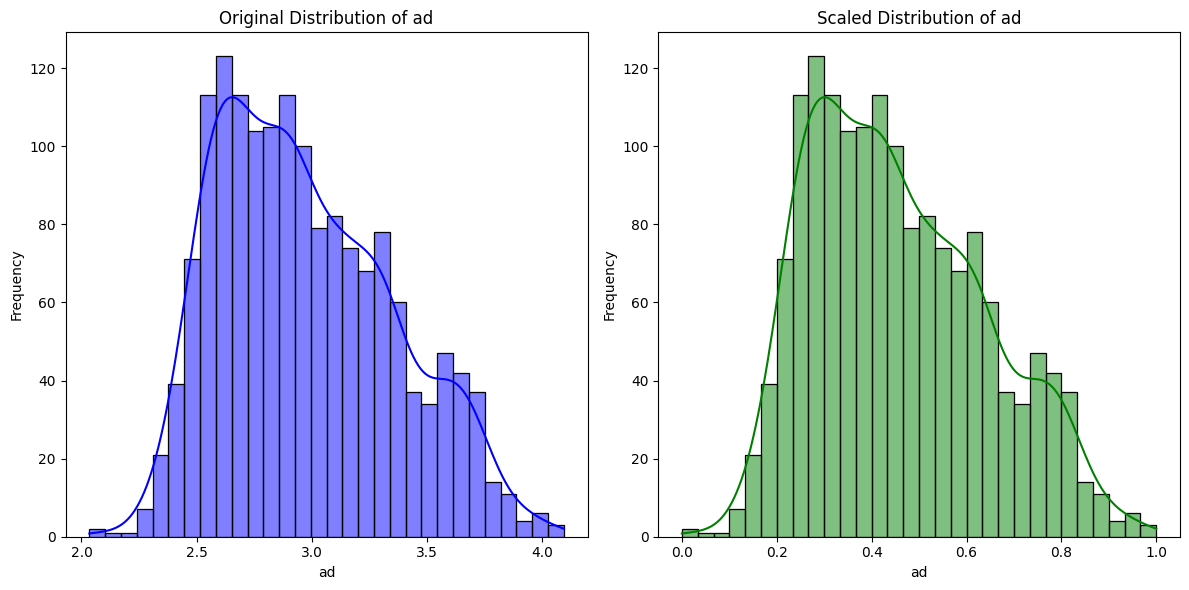

Масштабування для 'n' (StandardScaler):


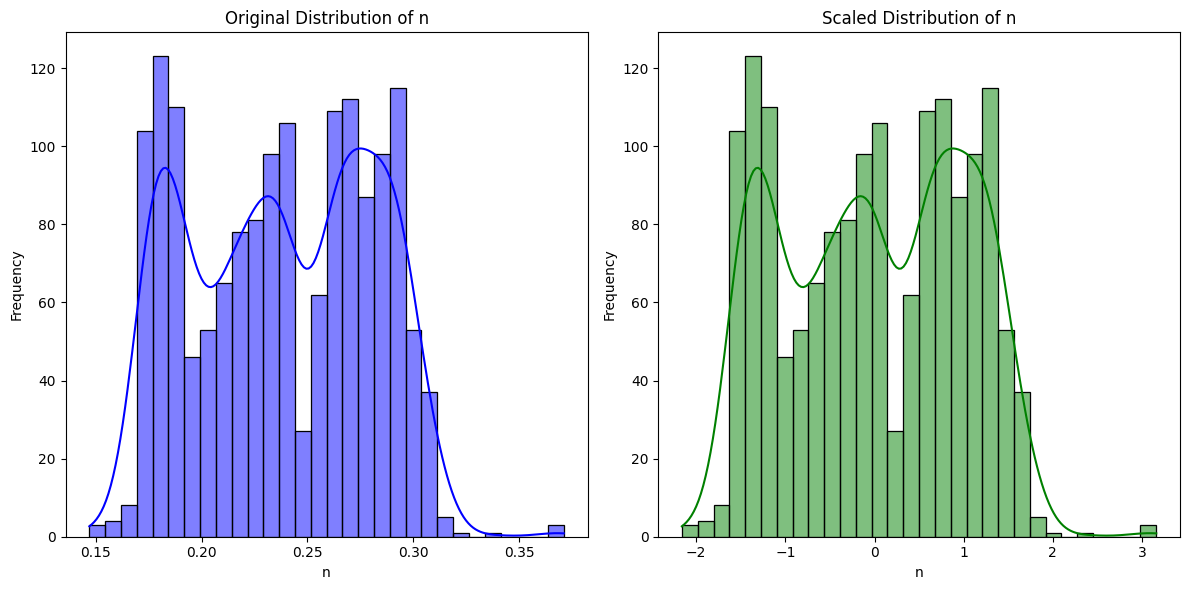

Масштабування для 'n' (MinMaxScaler):


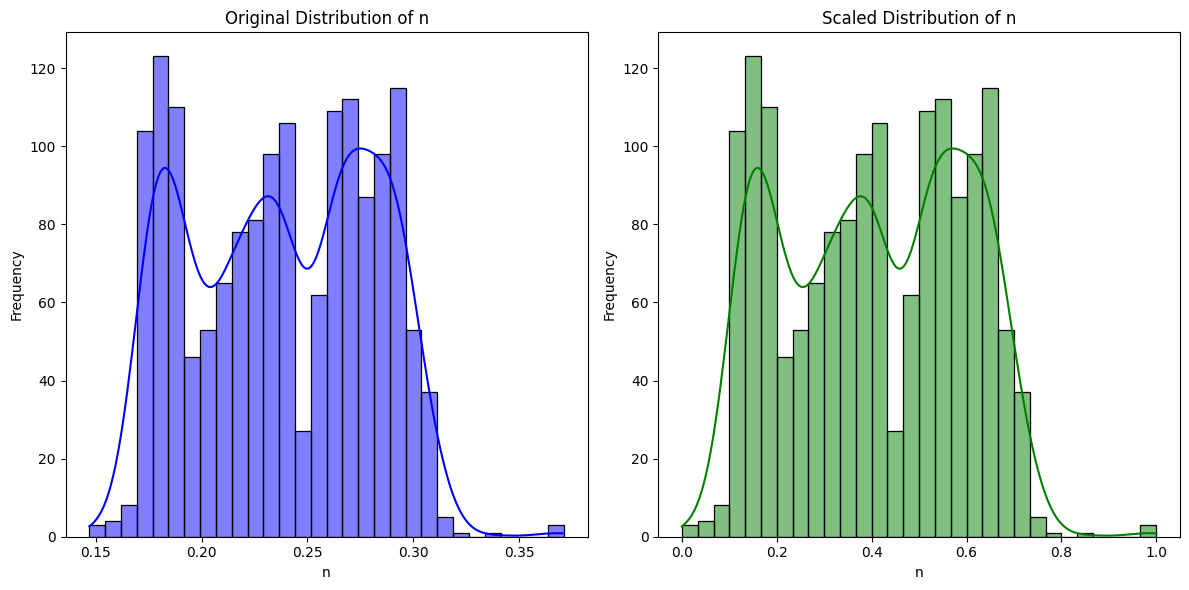

Масштабування для 'tp' (StandardScaler):


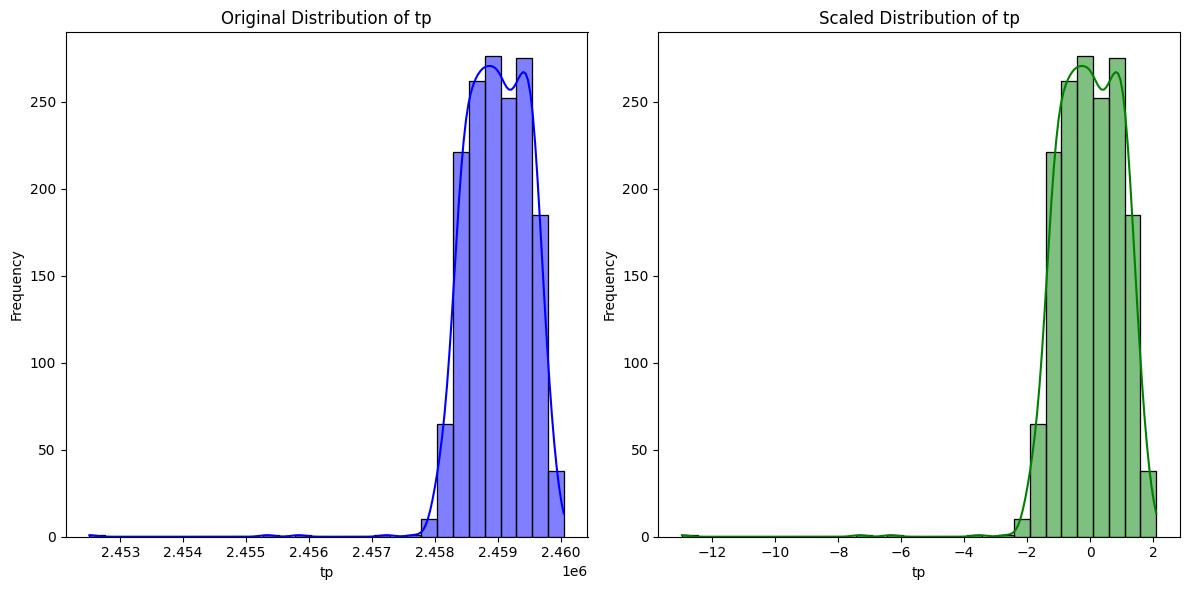

Масштабування для 'tp' (MinMaxScaler):


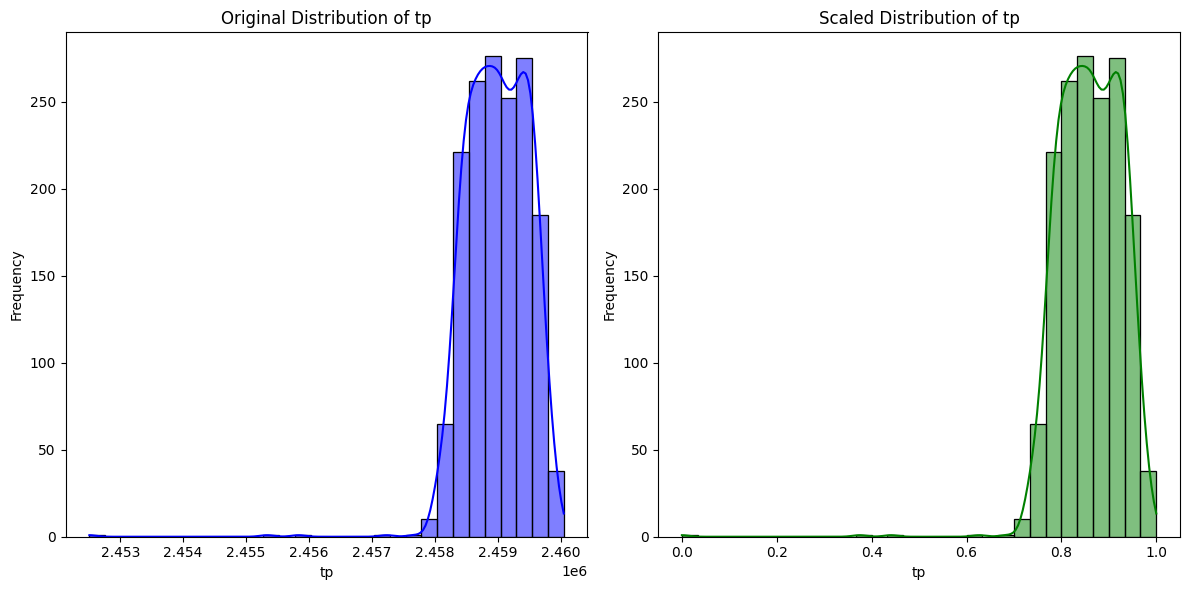

Масштабування для 'per' (StandardScaler):


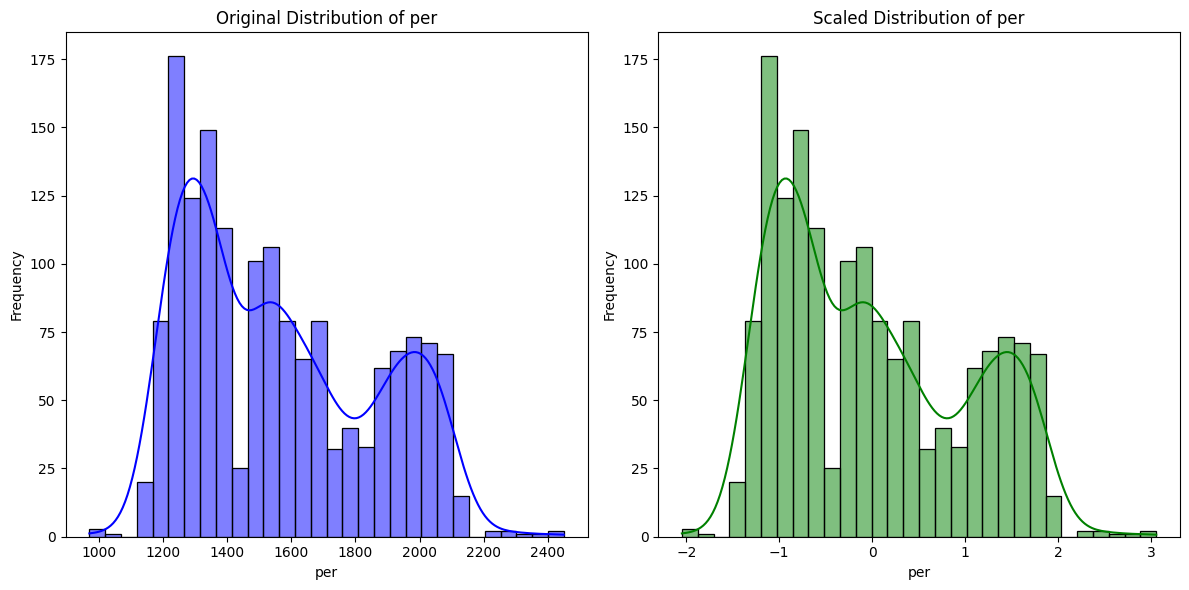

Масштабування для 'per' (MinMaxScaler):


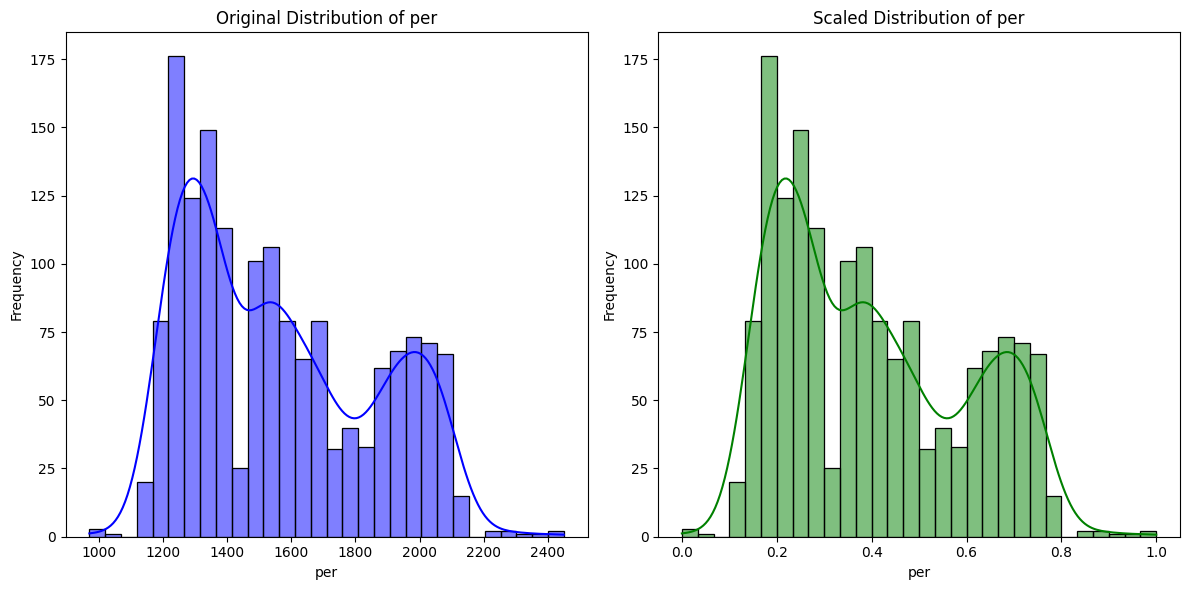

Масштабування для 'rms' (StandardScaler):


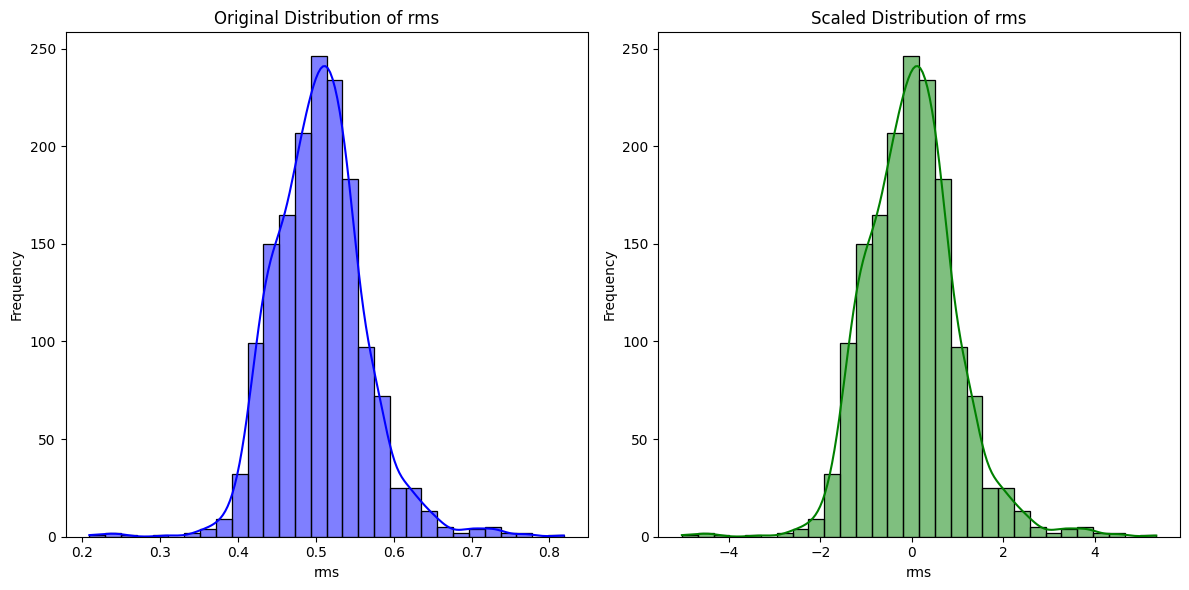

Масштабування для 'rms' (MinMaxScaler):


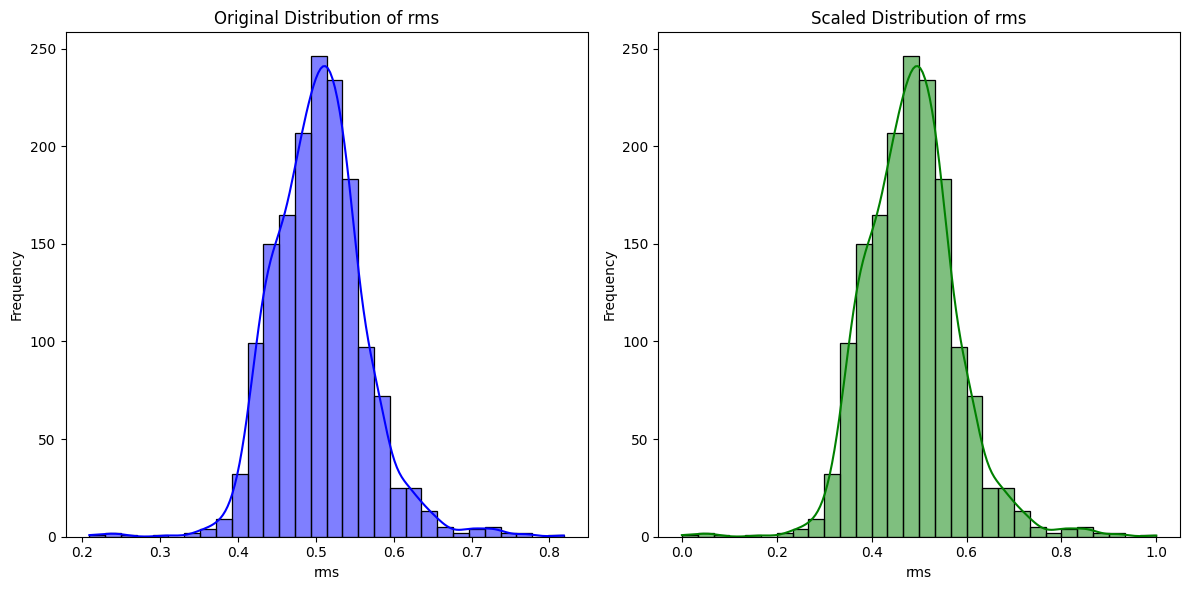

In [50]:
# Перевірка масштабування для всіх числових колонок
for feature in numerical_features:
    print(f"Масштабування для '{feature}' (StandardScaler):")
    plot_scaled_features(df, df_standard_scaled, feature)

    print(f"Масштабування для '{feature}' (MinMaxScaler):")
    plot_scaled_features(df, df_minmax_scaled, feature)

In [51]:
# Збереження опрацьованого датасету як копію
processed_dataset_path = "processed_dataset.csv"
df.to_csv(processed_dataset_path, index=False)

print(f"Опрацьований датасет успішно збережено як {processed_dataset_path}")

Опрацьований датасет успішно збережено як processed_dataset.csv


## Висновок

1. **Обробка пропущених значень**:
   - Для бінарних змінних використав логічне заповнення (наприклад, значення `'N'` для небезпечних астероїдів).
   - Для числових змінних, таких як `diameter` та `albedo`, провів обчислення на основі формул чи заповнив середніми значеннями у групах.
   - Видалив колонки, які не несли корисної інформації (наприклад, `prefix`).

2. **Аналіз категоріальних змінних**:
   - Визначив категоріальні колонки, перевірив унікальні значення в них. Це дозволило зрозуміти, які змінні потрібно закодувати.
   - Використав **Label Encoding** для бінарних змінних та **One-Hot Encoding** для багатозначних категоріальних змінних. Побачив, що це зменшило вплив текстових значень на модель.

3. **Обробка числових аномалій**:
   - Виявив аномалії за допомогою гістограм, Q-Q графіків та бокс-плотів.
   - Визначив верхню та нижню межі для числових змінних, видалив записи, які не відповідали допустимим межам. Це покращило розподіл даних.

4. **Масштабування числових даних**:
   - Використав **StandardScaler** для нормалізації даних та **MinMaxScaler** для переведення значень у діапазон [0, 1]. Це забезпечило узгодженість числових змінних для подальшого аналізу.

### Особливості
- Я помітив, що дані були дуже нерівномірними, особливо у числових змінних, таких як `diameter`. Видалення аномалій значно покращило вигляд розподілу.
- Категоріальні змінні, наприклад, `neo` та `pha`, мали специфічні унікальні значення, що вимагало комбінованого підходу до їх обробки.
- Масштабування допомогло вирівняти різні одиниці виміру числових змінних, що зробить модель більш стабільною.

Загалом, підготовлені дані стали набагато якіснішими для побудови моделі машинного навчання.